In [1]:
import pandas as pd
from Bio import pairwise2
from Bio.Cluster import Node, Tree
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from Bio import Cluster
from scipy.cluster import hierarchy as HIR
from scipy.spatial.distance import squareform
from tqdm import tqdm
from collections import defaultdict
from Bio.Align import substitution_matrices
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
import logomaker as lm
from collections import Counter

In [6]:
def get_ctrl_stats(wantdf,ctrldf):
    cntrl_max = []
    cntrl_mean = []
    cntrl_rnds = []
    cntrl_fracs = []
    cntrl_rnd_and_frac_count = []
    for p in wantdf['Protein']:
        odf = ctrldf[ctrldf['Protein']==p].copy()
        if len(odf) == 0:
            cntrl_max.append(0)
            cntrl_mean.append(0)
            cntrl_rnds.append([])
            cntrl_fracs.append([])
            cntrl_rnd_and_frac_count.append(len(odf))
        else:
            desc = odf['Percentage'].describe()
            cntrl_max.append(desc['max'])
            cntrl_mean.append(desc['mean'])
            cntrl_rnds.append(odf['round'].unique().tolist())
            cntrl_fracs.append(odf['fraction'].unique().tolist())
            cntrl_rnd_and_frac_count.append(len(odf))
    wantdf['cntrl_%max'] = cntrl_max
    wantdf['cntrl_%mean'] = cntrl_mean
    wantdf['cntrl_rnds'] = cntrl_rnds
    wantdf['cntrl_fracs'] = cntrl_fracs
    wantdf['cntrl_rnd_and_frac_count'] = cntrl_rnd_and_frac_count
    return wantdf

In [31]:
def remove_flanks(seq,lib):
    if lib == 7: return seq[3:-5] #if (seq[:3]=='SAC') & (seq[-5:]=='CGGGS'): return True
    elif lib == 12: return seq[1:-4] #if (seq[0]=='S') & (seq[-4:]=='GGGS'): return True   
    elif lib == 16: return seq[1:-1] #if (seq[0]=='S') & (seq[-1]=='S'): return True  
    elif lib == 20: return seq[1:-1] #if (seq[0]=='S') & (seq[-1]=='S'): return True  
    else: return 'Error: library "{}" does not exist'.format(lib)

# Identify selective peptides for each cell line

perhaps only consider round 3 for cell line of interest (this is enriched cell line), but we can filter round 3 out later.<br>
do not separate by fraction. if peptide is found anywhere in controls it should be excluded.<br>
exclusion criteria: if peptide occurs more than 0.01% (0.05%) in any round or fraction of control, it is not considered selective'''

In [2]:
mydf = pd.read_csv('all_NGS_data_combined.csv',sep=',')
vivodf = mydf[mydf['experiment_type']=='in-vivo']
vitrodf = mydf[mydf['experiment_type']=='in-vitro']

In [3]:
outdf = pd.DataFrame()

### 1a. ENGKOmice-PS selective peptides

In [4]:
idf = mydf[mydf['cell_line']=='ENGKOmice-PS'].copy() #cell line of interest
ndf = mydf[mydf['cell_line']=='ENGKOmice-kidney'].copy() # control cell line

In [7]:
odf = get_ctrl_stats(idf,ndf)

In [9]:
# 2619 peptides ctrl%max==0
# 3427 unique peptides in cell line of interest
selectivity_cutoff = 0.01 # % of reads in tested sample
odf[odf['cntrl_%max']<=selectivity_cutoff]['Protein'].nunique()
#idf[idf['cntrl_%max']==0]['Protein'].nunique()

3333

In [10]:
outdf = pd.concat([outdf,odf])

### 1b. Tie2LF-Xenograft selective peptides

In [11]:
ctrl_clines = ['Kidney-Xenograft','Liver-Xenograft','WT-Xenograft']
idf = mydf[mydf['cell_line']=='Tie2LF-Xenograft'].copy() #cell line of interest
ndf = mydf[mydf['cell_line'].isin(ctrl_clines)].copy() # control cell line

In [12]:
odf = get_ctrl_stats(idf,ndf)

In [13]:
outdf = pd.concat([outdf,odf])

### 2a. in-vitro selective peptides

In [14]:
vitrodf.cell_line.unique()

array(['CCM2-iEC', 'ENG-iEC', 'HUAEC', 'HUVEC', 'KRIT1-iEC', 'Tie2LF-iEC',
       'WT-iEC', 'iECALK1'], dtype=object)

In [15]:
#takes 10-15mins
clines_ofint = ['CCM2-iEC','ENG-iEC','KRIT1-iEC','Tie2LF-iEC','iECALK1']
ctrl_clines = ['WT-iEC','HUAEC','HUVEC']
for cloi in clines_ofint:
    print(cloi)
    idf = mydf[mydf['cell_line']==cloi].copy() #cell line of interest
    cdf = mydf[mydf['cell_line'].isin(ctrl_clines)].copy() # control cell line(s)
    odf = get_ctrl_stats(idf,ndf)
    outdf = pd.concat([outdf,odf])

CCM2-iEC
ENG-iEC
KRIT1-iEC
Tie2LF-iEC
iECALK1


### remove unwanted peptides (unselective peptides) using cutoff value

In [16]:
selectivity_cutoff = 0.01 # % of reads in tested sample
cutdf = outdf[outdf['cntrl_%max']<=selectivity_cutoff]

In [ ]:
print(len(outdf),len(cutdf))

In [17]:
cutdf.to_csv('Selective_peptides_{}%cutoff.csv'.format(selectivity_cutoff),sep=',')

# Preparation for clustering. Pairwise similarity comparisons

Multiple sequence alignment methods are not viable for such short peptides, therefore pairwise sequence comparisons use used make a similarity/distance matrix of all peptides. a pairwise comparison has significantly higher computational demand.

In [32]:
# load data
mydf = pd.read_csv('Selective_peptides_0.01%cutoff.csv',sep=',')
mydf.drop(['Unnamed: 0.1','Unnamed: 0'],axis=1,inplace=True)

In [33]:
mydf['cell_line'].unique()

array(['ENGKOmice-PS', 'Tie2LF-Xenograft', 'CCM2-iEC', 'ENG-iEC',
       'KRIT1-iEC', 'Tie2LF-iEC', 'iECALK1'], dtype=object)

### remove flanks from peptides

In [34]:
# we removed flanks because keeping them woud mean the similarity score between sequences would be artificially boosted.
Prot_noflnks = []
for p,l in zip(mydf['Protein'],mydf['library']):
    newp = remove_flanks(p,l)
    Prot_noflnks.append(newp)
mydf['Protein_FlanksRemoved'] = Prot_noflnks

In [35]:
mydf.to_csv('Selective_peptides_0.01%cutoff_noflanks.csv',sep=',')

In [36]:
mydfr3 = mydf[mydf['round']==3].copy()

In [9]:
# generate and save similarity matrix

In [23]:
blosum62 = substitution_matrices.load("BLOSUM62")

In [24]:
# this can take some time. 7lib: 30min-1h
# using blosum62 matrix for pairwise2 increases computation time dramatically!!
seqsim_dict = defaultdict(dict)
for lib, df in mydfr3.groupby('library'):
    protlist = df['Protein_FlanksRemoved'].unique()
    print('lib:',lib,'nunique:',len(protlist))
    simmat = np.zeros([len(protlist),len(protlist)])
    seqsim_dict[lib] = defaultdict(dict)
    for i,P1 in enumerate(protlist):
        if i%100 == 0: print(int(i/len(protlist)*100), end='-')
        for j,P2 in enumerate(protlist[i:]):
            if P2 not in seqsim_dict[lib]: seqsim_dict[lib][P2] = defaultdict(dict)
            k=i+j
            #if i == j: seqsim_dict[lib][P1][P2] = 0
            #alignment = pairwise2.align.globalds(P1, P2, blosum62, -0.5, -0.05 ,score_only=True)
            alignment = pairwise2.align.globalms(P1, P2 ,1.5,0,-0.5,-0.1,score_only=True)
            algn = round(alignment,2)
            #if algn < 0: print(algn,P1,P2)
            simmat[i,k] = algn
            simmat[k,i] = algn
            seqsim_dict[lib][P1][P2] = algn
            seqsim_dict[lib][P2][P1] = algn
    print('100')
    ldf = pd.DataFrame(simmat)
    ldf['Protein'] = protlist
    ldf.set_index('Protein',inplace=True)
    ldf.columns = protlist
    ldf.to_csv('similarity_matrix_lib_{}.csv'.format(lib),sep=',')

lib: 7 nunique: 1393
0-7-14-21-28-35-43-50-57-64-71-78-86-93-100
lib: 12 nunique: 6027
0-1-3-4-6-8-9-11-13-14-16-18-19-21-23-24-26-28-29-31-33-34-36-38-39-41-43-44-46-48-49-51-53-54-56-58-59-61-63-64-66-68-69-71-73-74-76-77-79-81-82-84-86-87-89-91-92-94-96-97-99-100
lib: 16 nunique: 6264
0-1-3-4-6-7-9-11-12-14-15-17-19-20-22-23-25-27-28-30-31-33-35-36-38-39-41-43-44-46-47-49-51-52-54-55-57-59-60-62-63-65-67-68-70-71-73-75-76-78-79-81-83-84-86-87-89-90-92-94-95-97-98-100
lib: 20 nunique: 9505
0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100


# Load similarity matrix data

In [25]:
# load similarity matrix and convert to normalized distance units.
simmatdict = {}
for lib in [7,12,16,20]:
    simdf = pd.read_csv('similarity_matrix_lib_{}.csv'.format(lib),sep=',',index_col=0)
    maxval = simdf.max().max()
    simdf2 = simdf.applymap(lambda x: 1-x/maxval)
    simmatdict[lib] = simdf2
    #display(lib,simdf2)

# clustering and dendrogram
##### example https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [37]:
mydfr3.cell_line.unique()

array(['ENGKOmice-PS', 'Tie2LF-Xenograft', 'CCM2-iEC', 'ENG-iEC',
       'KRIT1-iEC', 'Tie2LF-iEC', 'iECALK1'], dtype=object)

In [38]:
# distance cutoffs for clustering criteria. value for each library
clustDcut = {'CCM2-iEC':{7:4.5,12:6,16:3.4,20:4.2},
             'ENG-iEC':{7:1.5,12:6.3,16:4.2,20:4.7},
             'KRIT1-iEC':{7:1.7,12:5.6,16:4.2,20:4},
             'Tie2LF-iEC':{7:4.5,12:5,16:2.6,20:3.6},
             'iECALK1':{7:3.5,12:4,16:2.1,20:3.3},
             'ENGKOmice-PS':{7:2,16:3.8},
             'Tie2LF-Xenograft':{7:2,12:3.1,16:3.2,20:4}
            }
#libmaxD = {7:7.5,12:12.5,16:20,20:25}

('Tie2LF-Xenograft', 20) ProtCount 1995 -

C:\Users\khnd877\AppData\Local\Temp\ipykernel_9816\2551419263.py:16: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = HIR.linkage(simmat, 'average')


cophenetic index: 0.978


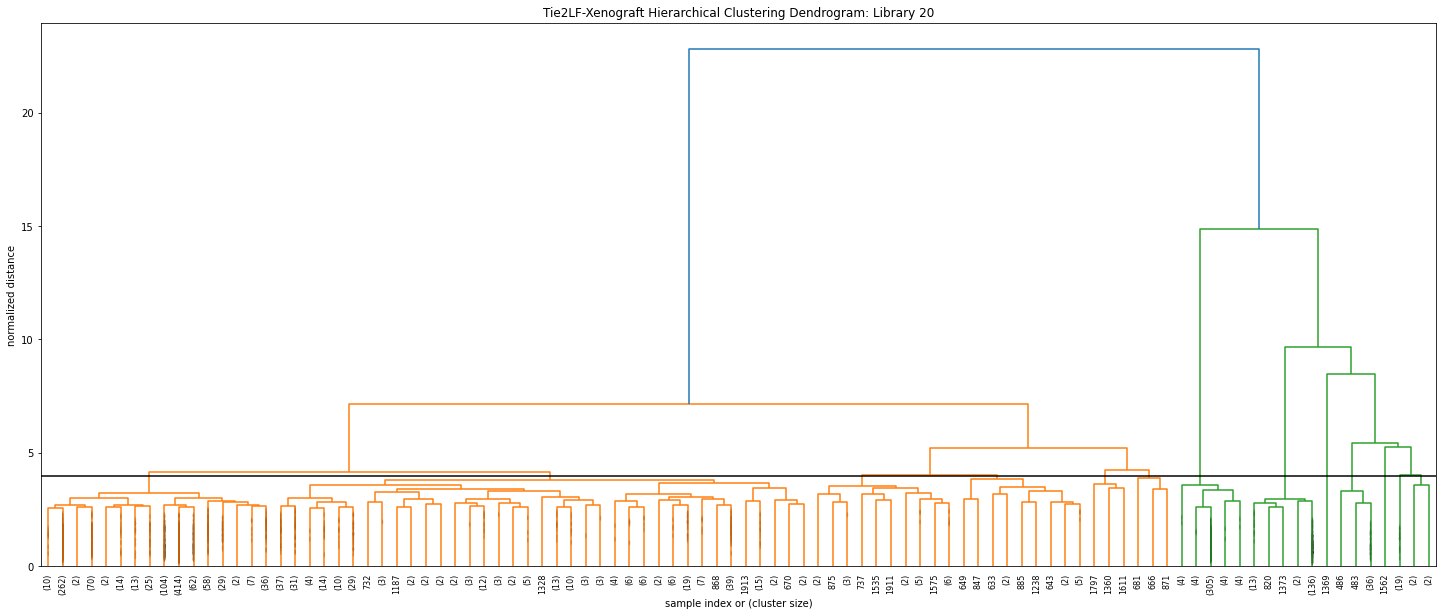

In [47]:
clust_df = pd.DataFrame()
for lc,df in mydfr3.groupby(['cell_line','library']):
    #if lc[0] != 'Tie2LF-Xenograft': continue #temp
    lib = lc[1]
    #if lib != 20: continue
    protlist = df['Protein_FlanksRemoved'].unique()
    print(lc,'ProtCount',len(protlist),end=' -')
    simmat = np.zeros([len(protlist),len(protlist)])
    for i,P1 in enumerate(protlist):
        for j,P2 in enumerate(protlist[i:]):
            k=i+j
            simmat[i,k] = simmatdict[lib][P1][P2]
            simmat[k,i] = simmatdict[lib][P2][P1]
    
    #condensed_dist_matrix = squareform(simmat)  #not sure if i should be using this, results look very different...      
    Z = HIR.linkage(simmat, 'average')
    # compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances
    c, coph_dists = cophenet(Z, pdist(simmat))
    print('cophenetic index:',round(c,3))
    plt.figure(figsize=(25, 10),facecolor='w')
    plt.title('{} Hierarchical Clustering Dendrogram: Library {}'.format(lc[0],lc[1]),size=12)
    plt.xlabel('sample index or (cluster size)')
    plt.ylabel('normalized distance')
    clustcount = 96
    HIR.dendrogram( Z, leaf_rotation=90, leaf_font_size=8,truncate_mode='lastp',p=clustcount,show_contracted=True)
    plt.axhline(y=clustDcut[lc[0]][lib],c='k')
    #plt.ylim(0,libmaxD[lib])
    plt.savefig('Dendrograms/maxclust_{}_{}_k{}.png'.format(lc[1],lc[0],clustcount), bbox_inches='tight')
    plt.show()
    plt.close()
    if len(protlist) <= 200: tmax = len(protlist)/10
    else: tmax = 20 
    clusters = fcluster(Z, tmax, criterion='maxclust')
    P2Cdict = {}
    for uprot,cidx in zip(protlist,clusters): P2Cdict[uprot] = cidx
    df['ClusterID'] = [P2Cdict[x] for x in df['Protein_FlanksRemoved']]
    clust_df = pd.concat([clust_df,df])
    #break

('Tie2LF-Xenograft', 7) ProtCount 110 -

C:\Users\khnd877\AppData\Local\Temp\ipykernel_9816\3911425308.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = HIR.linkage(simmat, 'average')


cophenetic index: 0.945


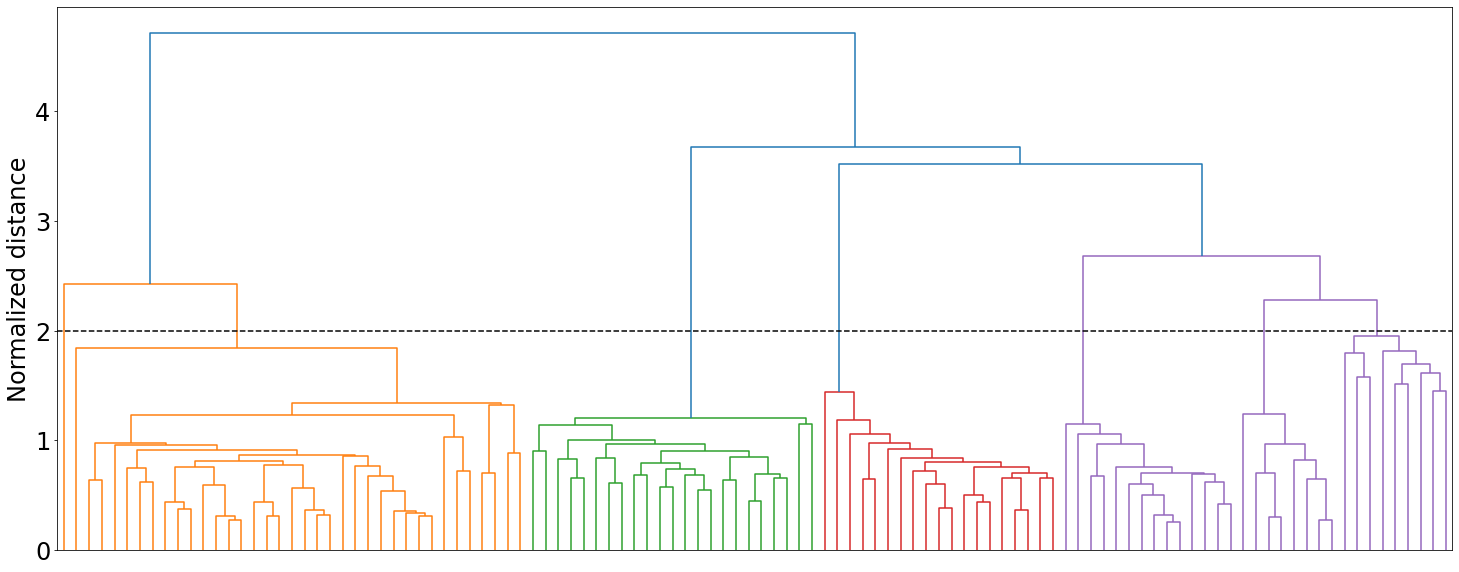

('Tie2LF-Xenograft', 12) ProtCount 697 -cophenetic index: 0.956


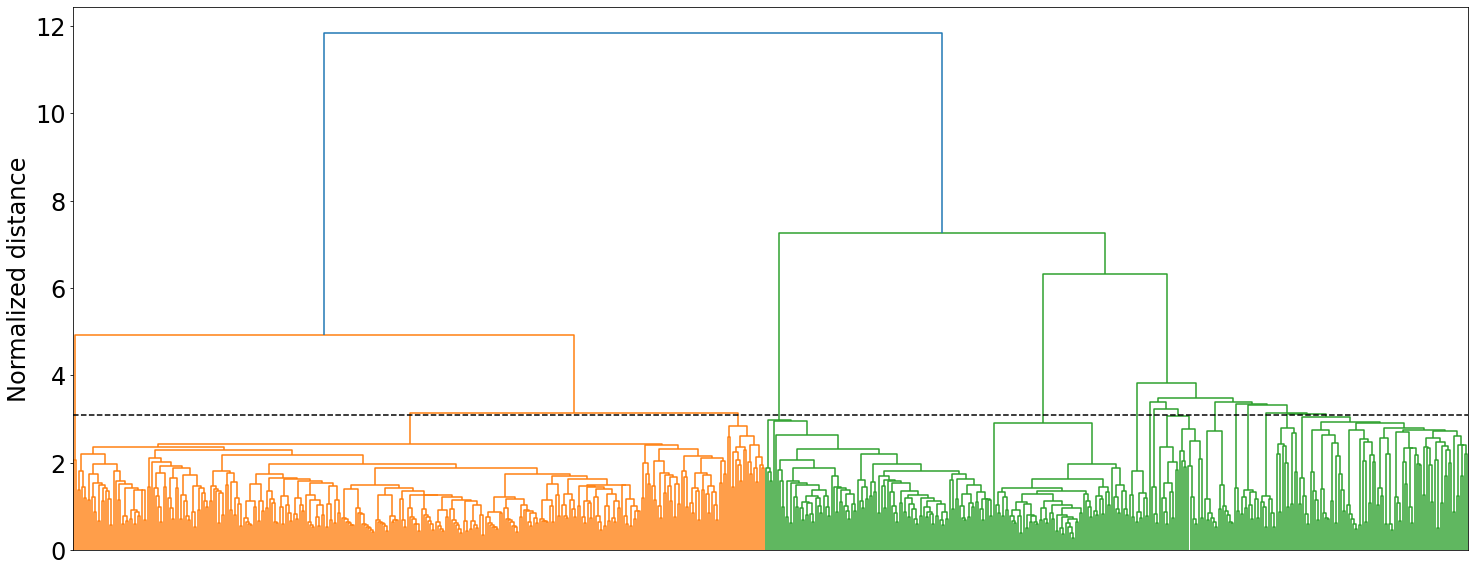

('Tie2LF-Xenograft', 16) ProtCount 1221 -cophenetic index: 0.986


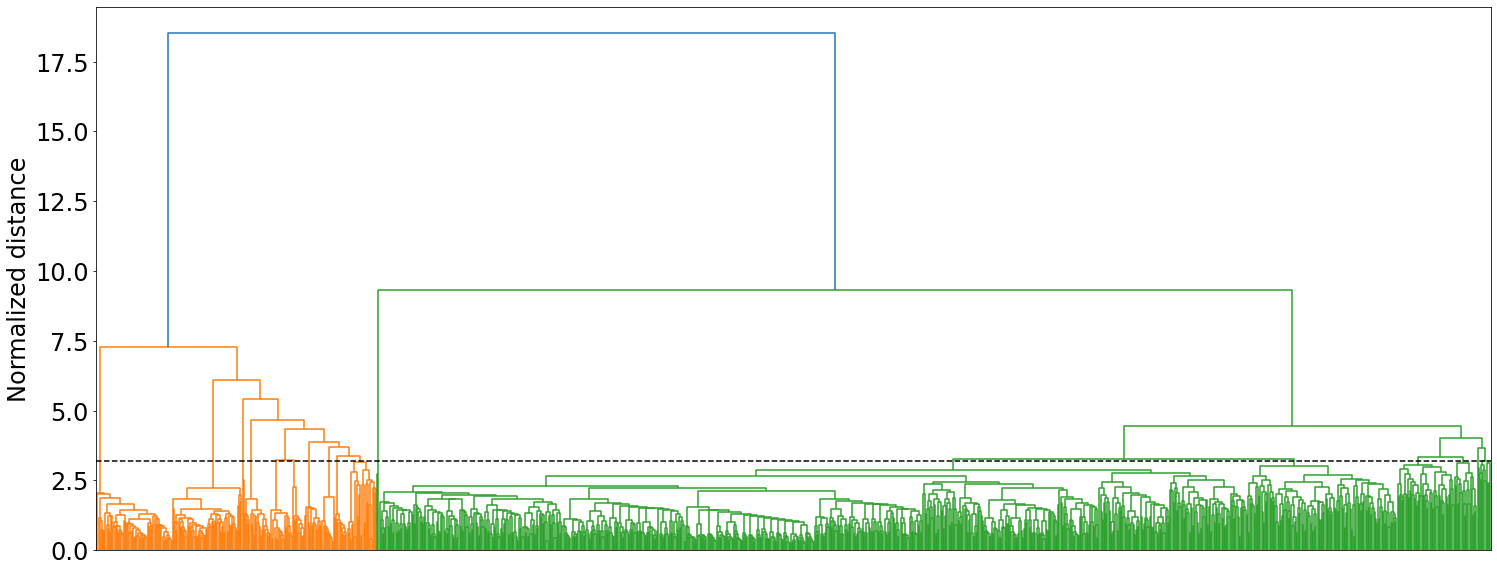

('Tie2LF-Xenograft', 20) ProtCount 1995 -cophenetic index: 0.978


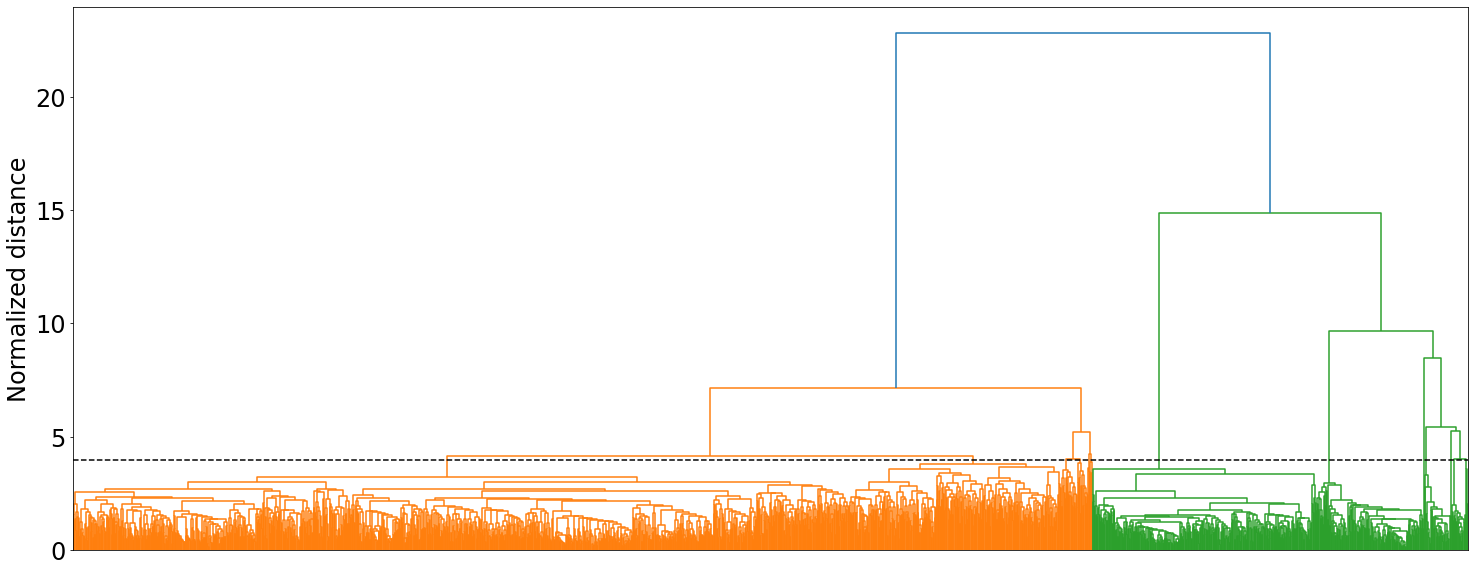

In [63]:
#just images for publication
clust_df = pd.DataFrame()
for lc,df in mydfr3.groupby(['cell_line','library']):
    if lc[0] != 'Tie2LF-Xenograft': continue #temp
    lib = lc[1]
    #if lib != 20: continue
    protlist = df['Protein_FlanksRemoved'].unique()
    print(lc,'ProtCount',len(protlist),end=' -')
    simmat = np.zeros([len(protlist),len(protlist)])
    for i,P1 in enumerate(protlist):
        for j,P2 in enumerate(protlist[i:]):
            k=i+j
            simmat[i,k] = simmatdict[lib][P1][P2]
            simmat[k,i] = simmatdict[lib][P2][P1]
    
    #condensed_dist_matrix = squareform(simmat)  #not sure if i should be using this, results look very different...      
    Z = HIR.linkage(simmat, 'average')
    # compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances
    c, coph_dists = cophenet(Z, pdist(simmat))
    print('cophenetic index:',round(c,3))
    plt.figure(figsize=(25, 10),facecolor='w')
    plt.ylabel('Normalized distance',size=24)
    HIR.dendrogram(Z, no_labels=True)
    plt.axhline(y=clustDcut[lc[0]][lib],c='k',linestyle='--')
    plt.yticks(size=24)
    plt.savefig('Figures/Dendrogram_full_{}_{}.png'.format(lc[1],lc[0]), bbox_inches='tight')
    plt.show()
    #break

In [20]:
clust_df.to_csv('maxclust_clustered_data.csv',sep=',',index=None)

In [30]:
#load clustering data
clust_df = pd.read_csv('clustered_data_customDist.csv',sep=',')
clust_df.drop('Unnamed: 0', axis=1, inplace=True)

In [34]:
consensusdict = defaultdict(dict)
for cl, df1 in clust_df.groupby(['cell_line','library']):
    print(cl,end=' ~ ')
    print(df1['Protein'].nunique(),'~')
    consensusdict[cl[0]][cl[1]] = defaultdict()
    for clstr, df2 in df1.groupby('ClusterID'):
        Pext = []
        for i,j in zip(df2.Count,df2.Protein): Pext = Pext + (i*[j])
        tc = len(Pext)
        uc = len(set(Pext))
        uP = set(Pext)
        print('Cluster {}: {} Total, {} Unique'.format(clstr,tc,uc))
        counts_mat = lm.alignment_to_matrix(sequences=df2.Protein.values, counts=df2.Count.values)
        lm.Logo(counts_mat,color_scheme='chemistry',)
        plt.title('{}_lib{}_clstr{}'.format(cl[0],cl[1],clstr))
        plt.savefig('P_Logos/{}_lib{}_clstr{}'.format(cl[0],cl[1],clstr))  
        plt.close()   
        consSeq = counts_mat.idxmax(axis=1).str.cat()
        consensusdict[cl[0]][cl[1]][clstr] = (consSeq,Pext)

('CCM2-iEC', 7) ~ 492 ~
Cluster 1: 3846 Total, 93 Unique
Cluster 2: 1359 Total, 56 Unique
Cluster 3: 2345 Total, 100 Unique
Cluster 4: 608 Total, 135 Unique
Cluster 5: 5305 Total, 75 Unique
Cluster 6: 546 Total, 33 Unique
('CCM2-iEC', 12) ~ 1329 ~
Cluster 1: 848 Total, 179 Unique
Cluster 2: 1573 Total, 171 Unique
Cluster 3: 261 Total, 121 Unique
Cluster 4: 275 Total, 116 Unique
Cluster 5: 190 Total, 85 Unique
Cluster 6: 1482 Total, 73 Unique
Cluster 7: 96 Total, 56 Unique
Cluster 8: 245 Total, 56 Unique
Cluster 9: 988 Total, 162 Unique
Cluster 10: 685 Total, 58 Unique
Cluster 11: 2226 Total, 138 Unique
Cluster 12: 77 Total, 51 Unique
Cluster 13: 389 Total, 63 Unique
('CCM2-iEC', 16) ~ 1078 ~
Cluster 1: 12 Total, 12 Unique
Cluster 2: 7 Total, 7 Unique
Cluster 3: 107 Total, 107 Unique
Cluster 4: 2170 Total, 710 Unique
Cluster 5: 429 Total, 74 Unique
Cluster 6: 760 Total, 168 Unique
('CCM2-iEC', 20) ~ 2274 ~
Cluster 1: 248 Total, 246 Unique
Cluster 2: 7337 Total, 1181 Unique
Cluster 3: 8 

Cluster 5: 419 Total, 122 Unique
Cluster 6: 266 Total, 21 Unique
Cluster 7: 607 Total, 61 Unique
Cluster 8: 46 Total, 38 Unique
Cluster 9: 701 Total, 39 Unique
Cluster 10: 29 Total, 25 Unique
Cluster 11: 414 Total, 37 Unique
Cluster 12: 389 Total, 48 Unique
Cluster 13: 83 Total, 52 Unique
Cluster 14: 187 Total, 39 Unique
('Tie2LF-iEC', 16) ~ 809 ~
Cluster 1: 1209 Total, 500 Unique
Cluster 2: 86 Total, 85 Unique
Cluster 3: 27 Total, 27 Unique
Cluster 4: 7 Total, 7 Unique
Cluster 5: 2 Total, 2 Unique
Cluster 6: 5 Total, 5 Unique
Cluster 7: 1217 Total, 171 Unique
Cluster 8: 11 Total, 11 Unique
Cluster 9: 1 Total, 1 Unique
('Tie2LF-iEC', 20) ~ 1771 ~
Cluster 1: 2 Total, 2 Unique
Cluster 2: 1 Total, 1 Unique
Cluster 3: 3720 Total, 938 Unique
Cluster 4: 71 Total, 71 Unique
Cluster 5: 2 Total, 2 Unique
Cluster 6: 30 Total, 30 Unique
Cluster 7: 1850 Total, 464 Unique
Cluster 8: 20 Total, 20 Unique
Cluster 9: 135 Total, 87 Unique
Cluster 10: 115 Total, 71 Unique
Cluster 11: 98 Total, 85 Unique


In [36]:
#check for best clusters across all libraries for each cell line
newdf = pd.DataFrame()
for k1,v1 in consensusdict.items():
    for k2,v2 in v1.items():
        #print(k1,k2,end=' \t-\t ')
        for k3,v3 in v2.items():
            tc = len(v3[1])
            uc = len(set(v3[1]))
            #print('Cluster {}: {} Total, {} Unique'.format(k3,len(v3),len(set(v3))))
            col_labs = ['Cell_line','lib','ClusterID','Peptide_reads','uPeptide_count','Consensus_seq','Peptides']
            newdf = pd.concat([newdf,pd.DataFrame([[k1,k2,k3,tc,uc,v3[0],v3[1]]],columns=col_labs)])
newdf.reset_index(drop=True,inplace=True)

In [37]:
ExtSeqOcc = {}
for g,df in newdf.groupby('Consensus_seq'): ExtSeqOcc[g] = list(df.Cell_line.values)

newcol = []
for cl,cs in zip(newdf['Cell_line'],newdf['Consensus_seq']):
    cl_list = ExtSeqOcc[cs].copy()
    if cl in cl_list: cl_list.remove(cl)
    newcol.append(list(set(cl_list)))
newdf['ConsensusSeq_promiscuity'] = newcol

In [304]:
for g,df in newdf.groupby('Cell_line'):
    print(g)
    df.sort_values('Peptide_reads',ascending=False,inplace=True)
    #display(df[:10])
    df.drop('Peptides',axis=1,inplace=True)
    df.to_csv('Consensus_seqs_{}.csv'.format(g),sep='\t',index=False)

CCM2-iEC
ENG-iEC
ENGKOmice-PS
KRIT1-iEC
Tie2LF-Xenograft
Tie2LF-iEC
iECALK1


In [39]:
newdf.to_csv('consensus_seqs_all.csv',sep='\t',index=False)

# check in which fraction each consensus seq occurs.

In [3]:
#load clustering data
clust_df = pd.read_csv('clustered_data_customDist.csv',sep=',')
clust_df.drop('Unnamed: 0', axis=1, inplace=True)
consendf = pd.read_csv('consensus_seqs_all.csv',sep='\t')

In [4]:
#convert string to list
newcol = []
for e in consendf['Peptides']: 
    plist = e.strip("[|]|'").split("', '")
    newcol.append(plist)
consendf['Peptides'] = newcol

In [5]:
allfraclist = []
for i,d in consendf.iterrows():
    print(i,end='')
    lib = d['lib']
    celline  = d['Cell_line']
    #print(lib,celline)
    sdf = clust_df[(clust_df['cell_line']==celline) & (clust_df['library']==lib)]
    #display(sdf)
    fraclist = []
    for P in d['Peptides']:
        #print(P)
        pdf = sdf[sdf['Protein']==P]
        fl = pdf.fraction.tolist()
        #print(fl)
        fraclist += fl
    
    allfraclist.append(fraclist)
    #display(sdf)

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302

In [6]:
newcoldata = []
for x in allfraclist:
    tlen = len(x)
    classcount = Counter(x)
    fracd = {}
    for k,v in classcount.items():
        fracd[k] = round(v/tlen*100,0)
    newcoldata.append(fracd)
consendf['Consensus_related_peptide_fractions'] = [Counter(x) for x in allfraclist]
consendf['Consensus_related_peptide_fractions%'] = newcoldata

In [7]:
allfraclist = []
for i,d in consendf.iterrows():
    lib = d['lib']
    celline  = d['Cell_line']
    sdf = clust_df[(clust_df['cell_line']==celline) & (clust_df['library']==lib)]
    cseq = d['Consensus_seq']
    pdf = sdf[sdf['Protein']==cseq]
    fl= pdf.fraction.tolist()
    allfraclist.append(fl)
consendf['exact_consensus_match_fractions'] = allfraclist

In [8]:
consendf.sort_values(['Cell_line','Peptide_reads'],ascending=False,inplace=True)

In [9]:
consendf.to_csv('consensus_seqs_all.csv',sep='\t',index=False)

In [10]:
for g,df in consendf.groupby('Cell_line'):
    df.sort_values('Peptide_reads',ascending=False,inplace=True)
    #display(df[:10])
    df.drop('Peptides',axis=1,inplace=True)
    #df.to_csv('Consensus_seqs_{}.csv'.format(g),sep='\t',index=False)
    #df.to_excel('Consensus_seqs_{}.xlsx'.format(g),index=False)

In [11]:
#convert string to list
newcol = []
for e in consendf['ConsensusSeq_promiscuity']: 
    plist = e.strip("[|]|'").split("', '")
    if plist == ['']: newcol.append([])
    else: newcol.append(plist)
consendf['ConsensusSeq_promiscuity'] = newcol

In [13]:
for g,df in consendf.groupby('Cell_line'):
    #display(df[:10])
    if 'ENG' not in g: continue
    for i,r in df.iterrows():
        #print(r.ConsensusSeq_promiscuity,len(r.ConsensusSeq_promiscuity))
        #if len(r.ConsensusSeq_promiscuity)>0: continue
        if r.lib not in [20,16]: continue
        print(g)
        print('lib:{} Cluster:{}'.format(r.lib,r.ClusterID))
        cseq = r.Consensus_seq
        print(cseq)
        pc = Counter(r.Peptides)
        if cseq in pc: 
            print('consensus seq exists')
            continue
            #print(cseq,':',pc[cseq])
        else:
            pcdf = pd.DataFrame.from_dict(pc,orient='index',columns=['count']).sort_values('count',ascending=False)
            display(pcdf[:8])

ENG-iEC
lib:20 Cluster:1
SQTAMRSSPNTATDWNYKPGVS


count
SQTAMRSSPNTATDWNYKQGVS    355
SQTAMRSSPNTATDLNYKPGVS    310
SQTAMRSSPNTATDWNYKPCVS    304
SQTAMRYSPNTATDWNYKPGVS    252
SQTAMRSYPNTATDWNYKPGVS    192
SQTAMRSSPNTATDWNYNPGVS    126
SQTAMRSSPNTATYCNYKPGVS    119
SQTAIRSSPNTATDWNYKPGVS     80

ENG-iEC
lib:16 Cluster:1
SDSSMLSNHWEPQAPLHS


count
SDSSMLSNNWEPQAPLHS    510
SDSSMLYNHWEPQAPLHS    406
SDSSMLSNHLEPQAPLHS    267
SDSSMLSNHWEPQAQLHS    158
SDSSMMSNHWEPQAPLHS    143
SDSSMLSNHCEPQAPLHS    130
SDSSMLSNHWEPQATLHS    128
SDSSMLSNHWEPHAPLHS     92

ENG-iEC
lib:16 Cluster:6
SFPHWQTINQVHPHQTTS


count
SFPHWHTINQVHPHQTTS    166
SFPHWQTINQVHPHHTTS    158
SFPHWQTINQVNPHQTTS    133
SFPHLQTINQVHPHQTTS    116
SFPHWQTINHVHPHQTTS    114
SFPHWQTINKVHPHQTTS     99
SFPHWQTINQVHPHKTTS     91
SFPHWQTINQVHQHQTTS     66

ENG-iEC
lib:20 Cluster:5
SHIYGEDVPLNHHDWQTPHIDS


count
SHIYGEDVTLNHHDWQTPHIDS     71
SHIYGEDVPLNHHDWQTPHIYS     66
SHIYGEDVPLNHHYWQTPHIDS     65
SHIYGEDVPLNNHDWQTPHIDS     63
SHIYGEDVQLNHHDWQTPHIDS     45
SHIYGEDVPLNHHDLQTPHIDS     37
SHIYCEDVPLNHHDWQTPHIDS     31
SHIYGEDVPLNHHDCQTPHIDS     25

ENG-iEC
lib:20 Cluster:8
SHVQPQSSYTLVPRHQHVTYGS


count
SHVKPQSSYTLVPRHQHVTYGS     59
SNVQPQSSYTLVPRHQHVTYGS     53
SHVQQQSSYTLVPRHQHVTYGS     49
SHVQPQSSYTLVPRHKHVTYGS     44
SHVQPQSSYTLVPLHQHVTYGS     42
SHVQPQSSYTLVPRHQHVTYCS     34
SHVQPQSSYTMVPRHQHVTYGS     34
SHVQPQSSYTLVTRHQHVTYGS     33

ENG-iEC
lib:16 Cluster:7
SGYEWFWHRENATTMWSS
consensus seq exists
ENG-iEC
lib:20 Cluster:7
SYEQPQYVNTPLKNDWNPKHHS


count
SYEQPQYVNTPLKNYWNPKHHS     49
SYEQPQYVNTPLKHDWNPKHHS     44
SHVQPQYVNTPLKNDWNPKHHS     31
SYEQPQYVNTPLKNDWNPKNHS     23
SYEQPQYVNTPLKNDWNPKHNS     21
SYEQPQYVNTPLKNEWNPKHHS     20
SYEQPQYVNTTLKNDWNPKHHS     17
SYEQPQYVNTPLKNDWNTKHHS     15

ENG-iEC
lib:16 Cluster:8
SWSIPWHYNANETWQMVS
consensus seq exists
ENG-iEC
lib:20 Cluster:10
SHISWQDHVPYHQHQQPVPGLS
consensus seq exists
ENG-iEC
lib:20 Cluster:9
STSNTTPWQTSWELMYAQQNYS


count
STSNTTPWQTSWELMYAQHNYS     72
STSNTTPWQTSWELMYAKQNYS     44
STSNTTPWHTSWELMYAQQNYS     28
STSNTTPWQTSLELMYAQQNYS     23
STSNTTPLQTSWELMYAQQNYS     16
STSNTTTWQTSWELMYAQQNYS     14
STSNTTQWQTSWELMYAQQNYS     11
STSNNTPWQTSWELMYAQQNYS     11

ENG-iEC
lib:16 Cluster:9
SHDSEWARMRQQHGKPYS
consensus seq exists
ENG-iEC
lib:16 Cluster:11
SHQFHDTKLHSAYLGIHS


count
SWQFEDWKLHSPYLGIHS     63
SHWNHGTAQRAHVEQPWS     56
SSYRPMTYHQYAKQPITS     33
SHQEQWEWDYMAASEYQS     23
SQYQHDNPLNFLHPHEPS     14
STPPPDVQWHLQHMGLAS      7
SHGTIPPESDLAHVQALS      7
SEHTTHGWFEHKWRHTKS      6

ENG-iEC
lib:16 Cluster:2
SDSSMLSNHWEPQAPLHS


count
SEYSMLSKHCEPHAPLHS      1
SDSCMLTNHWEPQARVLS      1
SYSSMVSRHSEPHAPLHS      1
SEYSMMSNHWDPQAPLHS      1
SEYSMLSNHSEQLAPLHS      1
SEYSLLSNQWEPLAPLHS      1
SEYSILSKHWEPQAPLHS      1
SYSSMLSNKKDPQPPLHS      1

ENG-iEC
lib:20 Cluster:2
SQTAMRSSPNTATDWNYNPGVS


count
SQTAMRSSQNNATDWIYITGFS      1
SQTAMRSSQITDNASTNSPVVS      1
SHSAMRSSQNTDPEWNYYPCVS      1
SQTGMRSSPKSATSFNYKPGFS      1
SQTDMRSSPHTDTECNYFAGVS      1
SQTAMSSYQSTATYWNHIPCVS      1
SRPAMSYSPNTATDWNYNRGGS      1
SQTAMRSYQKTATDSNYSPGGS      1

ENG-iEC
lib:16 Cluster:13
SYAPMNRGHQIMQPRIES


count
SYAPMNRGHQIMQPLIES     17
SYAPMNRGHQIMQPSIES      8
SYAPMNRGHHIMQPRIES      5
SYAPMNRGNQIMQPRIES      3
SYAPMNRGHKIMQPRIES      2
SYAPMIRGHQIMQPRIES      2
SYAPMNSGHQIMQPLIES      1
SYAPMNSCHQIMQPRIES      1

ENG-iEC
lib:16 Cluster:10
SEKVWGYVDHPHWMYHAS


count
SEKVWGYVDHPHLMYHAS      2
SEKVWGYVDHPHWMYHTS      2
SEKVWGYVDHPQWMYHAS      2
SEKVWGYVDHPHWMYHGS      2
SEKVWGYFDHPHWMYHAS      2
SEKVWGYVDDPHCMYHAS      1
SEKVWGYVDHPHCLYHAS      1
SEKVWGFVDHPHWMYHAS      1

ENG-iEC
lib:16 Cluster:4
SDSSMLSNHWEPQARVHS


count
SEYCMLDNHWEPVARLVS      1
SVSSMLTIRWELQAPLDS      1
SDSTMLTKHCETQSPVHS      1
SESSKLSTQWQQQAPLVS      1
SDTTMMSKHWEPQARVHS      1
SDSCKLSKHWEPLARVVS      1
SFSNLLSNQREPQDPLNS      1
SESSMMSNIWDTLSPLHS      1

ENG-iEC
lib:20 Cluster:12
SYPEKQGWWSPVEHHTVNTTNS


count
SYPEKQGWCSPVEHHTVNTTNS      4
SYPEKQCWWSPVEHHTVNTTNS      4
SYPEKHGWWSPVEHHTVNTTNS      1
SYPEKQGWWSPVEHHNVNTTNS      1
SYPEKQGWWSPVENHTVNTTNS      1
SYAEKQGWWSPVEHHTVNTTNS      1
SYAENQGWWSAVEHHTVNTTNS      1
SYPDKQGGWSPFEHHTVNPPNS      1

ENG-iEC
lib:20 Cluster:4
SQTAMRSSPNTATDWNYNPCVS


count
SQTGMRSTPKTDTVFTFNAGVS      1
SQSPKRSSPNTDTECKYYPEVS      1
SQTSMSSSTNTDTYCKNKQCVS      1
SHNAMHSSPLTATDWKYTPVVS      1
SHTDMRSSTNTAPALNNNPFGS      1
SDNAMRSSQNTSTVLIYLTCVS      1
SHAAKRSSPNPVNDWNYTPVVS      1
SQTAKRTSQNTASHRNYNPRDS      1

ENG-iEC
lib:16 Cluster:12
SFPQTYRLQHQMNGRINS
consensus seq exists
ENG-iEC
lib:16 Cluster:5
SFQHWQTIKEVHPHHTHS


count
SLQHWQTKKQVHPLLTSS      1
SLKHWQTINHVNQLLSTS      1
SYQHLQTIKEVQPIHTPS      1
SFPDMQTIQEDHPHPHHS      1
SFADWLTNKLVHPHHINS      1

ENG-iEC
lib:16 Cluster:3
SEYSMVSIHGDPQAPLHS


count
SEYSMMSIRLDPQATLHS      1
SDSSRVSTHGGKKSPLHS      1
SEYSMVSKLYEPNPPLDS      1
SVTAMLSIQRDPQAPQHS      1

ENG-iEC
lib:20 Cluster:6
SHFYAQDVPLNHHDWHTPLFDS


count
SHFDGQYVPLHLNHWTTPKIDS      1
SHIYAEDVPLNNHDWHTPLFVS      1
SHMYSHAVPLKHNDWQNPHIDS      1
SHNYVQDDQLNHHDWKYPLFVS      1

ENG-iEC
lib:20 Cluster:3
SENAMGCCPKAASECNSIPCVS


count
SQNAMSSSPKAASECNSIRCVS      1
SENAMGCCTTTHTEWNYKPCVS      1

ENG-iEC
lib:20 Cluster:11
SNDHPQSDNTPLKKKTKPKDDS


count
SNDHQQYDTTPLKNSTNTNHDS      1
SYDQPQSDNTRLNKKWKPKDVS      1

ENG-iEC
lib:16 Cluster:14
SGCCMMSRHRVPLPPVVS
consensus seq exists
ENG-iEC
lib:20 Cluster:13
SNYNTNASKTSFDLMKDQNNFS
consensus seq exists
ENG-iEC
lib:20 Cluster:14
SQDEKLSSDTRVPPRQNFPYVS
consensus seq exists
ENGKOmice-PS
lib:16 Cluster:2
SHGTIPPESDLAHVQAFS


count
SHGTIPPESDLGLVQAFS    212
SHGTIPPESDLAHVQGFS    138
SHGTIPPESDLALVLAFS    111
SHGTIPPESDVAHVQAFS     96
SHGTIPPESDLAIVQAFS     59
SHGTIPPESDLSHVQAFS     50
SHGTIPPESDVGHVQAFS     44
SHGTIPLESDLAHVQAFS     44

ENGKOmice-PS
lib:16 Cluster:6
SFISKQPPPPGAERYPFS
consensus seq exists
ENGKOmice-PS
lib:16 Cluster:7
SVKQEWSSMTKRWSIPVS


count
SVKQEWSSMTKRWSIRVS     11
SVKQEWSSMTKSWSIPVS     10
SVKQEWSSMTKRWAIPVS      7
SVKQEWSSMTKPWSIPVS      6
SVKQEWSSMTKRWYIPVS      6
SVKQEWSSMTKRWSIPFS      6
SVKQEWSSITKRWSIPVS      5
SVKQEWSSMSKRWSIPVS      4

ENGKOmice-PS
lib:16 Cluster:11
SDQSMWEWNYEPQAQLQS


count
SDSSMLSNHWEPQAPLHS     19
SDGSPVYTNLWHRQQGQS     10
SEHTTHGWFEHKWRHTKS     10
SHQEQWEWDYMADSEYQS      9
SHQEQWEWDYMGASEYQS      6
SWQFEDWKLHCPYLGIHS      3
SQRHMAAVAEEDMLARSS      3
SFPHWQTINQVHPHQTTS      3

ENGKOmice-PS
lib:16 Cluster:3
SHGTIPPESDLAHVQAFS


count
SHGTITPDSDLAHFLAVS      1
SDGTIAPYSDMAHVKAFS      1
SHGTIPPESYLDLVQVFS      1
SHGTIPQDSDMDHVQAFS      1
SHGTIQPDSDLGHVKAFS      1
SHGTIPPYSELAHFKAFS      1
SHGTIPPESDVGLVQTFS      1
SHGTIPPESDVVLVQVFS      1

ENGKOmice-PS
lib:16 Cluster:8
SEKVWGYVDHPHWMYHAS


count
SEKVWGYVDHPQWMYHAS      3
SEKVWGYVDHQHWMYHAS      2
SEKVWGYVDHPDWMYHAS      2
SEKVWGYVDHPPWMYHAS      2
SEKVWGYVDHPHWLYIAS      2
SEKVWGYVDHPRWMYHDS      1
SEKVWGYVDHPHWMYLAS      1
SEKVWGYVDHPHWLYHAS      1

ENGKOmice-PS
lib:16 Cluster:9
SSYRPMTYHQYMKQRITS


count
SSYRPMTYHQYDKQPITS      3
SYAPMNRGHQIMQPRIDS      2
SSYRPMTYHQYAKQQITS      1
SYAPMNRGHQIMQPRMES      1
SSYRPKTYHQYGKQPITS      1
SSYRPMTYHQYGKQPITS      1
SSYRPMTYNQYAKQPITS      1
SSYRTMTYHQYAKQPITS      1

ENGKOmice-PS
lib:16 Cluster:10
SGYEWFWHRENANTMWSS
consensus seq exists
ENGKOmice-PS
lib:16 Cluster:1
SHGTIPPDSDLAHVQAFS


count
SHGTLPPESEVGDVRAFS      1
SHVTIQRQSDLAHFLAFS      1
SHGTIHKYSDMAHVKAIS      1
SHGTRPPYSDMDNVNACS      1
SHGTSPPDYDLVVVLAFS      1
SHGTIPRDSDVALVKAIS      1
SDDTIHPASELAHVQAIS      1
SDGTIHPGSEMAHVQAFS      1

ENGKOmice-PS
lib:16 Cluster:4
STPPPDVQWHLQHMGLAS
consensus seq exists
ENGKOmice-PS
lib:16 Cluster:5
SHCPVTAESNMPDVQAFS
consensus seq exists


# make other graphs

In [307]:
#make df for graphs below
newdf = pd.DataFrame()
for k1,v1 in consensusdict.items():
    for k2,v2 in v1.items():
        #print(k1,k2,end=' \t-\t ')
        reads = 0
        ureads = 0
        for k3,v3 in v2.items():
            tc = len(v3[1])
            uc = len(set(v3[1]))
            #print('Cluster {}: {} Total, {} Unique'.format(k3,len(v3),len(set(v3))))
            reads += tc
            ureads += uc
        col_labs = ['CL','lib','tot_lib_reads','tot_lib_ureads','clusterDict']
        newdf = pd.concat([newdf,pd.DataFrame([[k1,k2,reads,ureads,v2]],columns=col_labs)])
newdf.reset_index(drop=True,inplace=True)

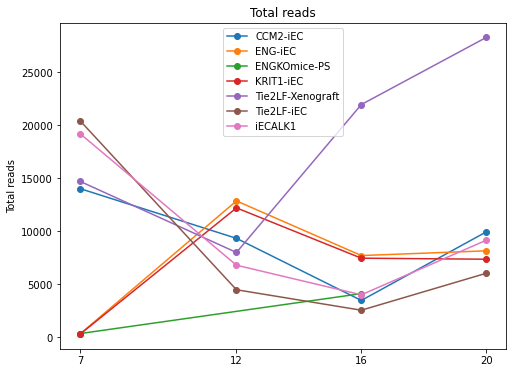

In [309]:
plt.figure(figsize=(8,6))
for g,d in newdf.groupby('CL'):
    plt.plot(d['lib'],d['tot_lib_reads'],label=g,marker='o')
plt.title('Total reads'); plt.ylabel('Total reads')
plt.xticks([7,12,16,20])
plt.legend()
plt.show()
plt.close()

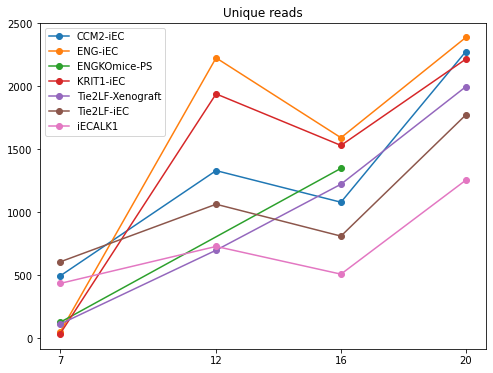

In [310]:
plt.figure(figsize=(8,6))
for g,d in newdf.groupby('CL'):
    plt.plot(d['lib'],d['tot_lib_ureads'],label=g,marker='o')
plt.title('Unique reads')
plt.xticks([7,12,16,20])
plt.legend()
plt.show()
plt.close()

# make figures like in the paper from Anders Christiansen et al.

In [2]:
mydf = pd.read_csv('all_NGS_data_combined.csv',sep=',')
newmydf = mydf[mydf['Count']>1].copy()

Plot1 r1:5724 r2:4929 r3:5287 - green:1004
Plot2 r1:101991 r2:93208 r3:100526 - green1:87043 green2:79026 green3:88664


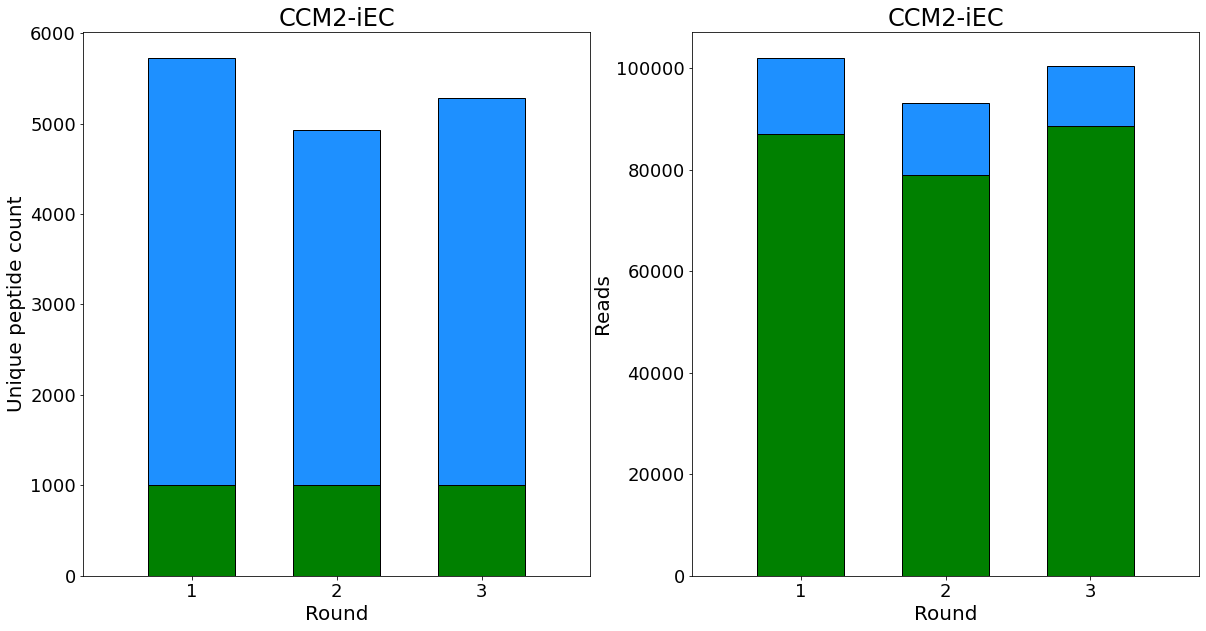

Plot1 r1:3873 r2:3710 r3:6498 - green:896
Plot2 r1:75091 r2:81230 r3:162481 - green1:71215 green2:77312 green3:153423


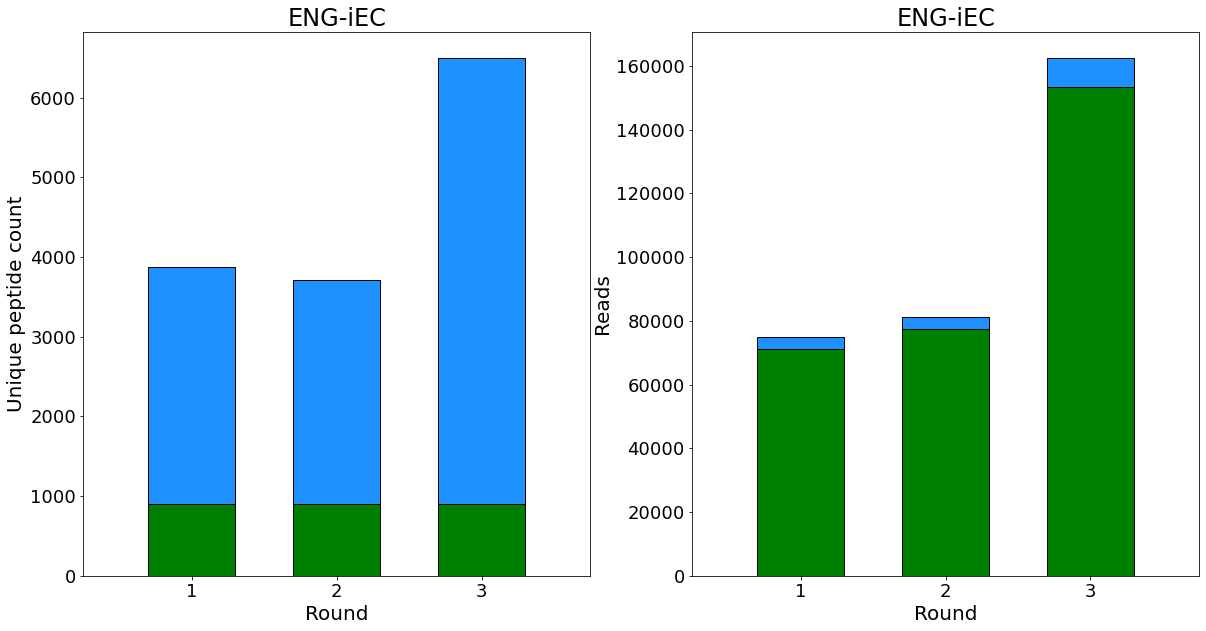

Plot1 r1:1652 r2:1465 r3:1536 - green:416
Plot2 r1:166109 r2:73933 r3:76024 - green1:162799 green2:72695 green3:74724


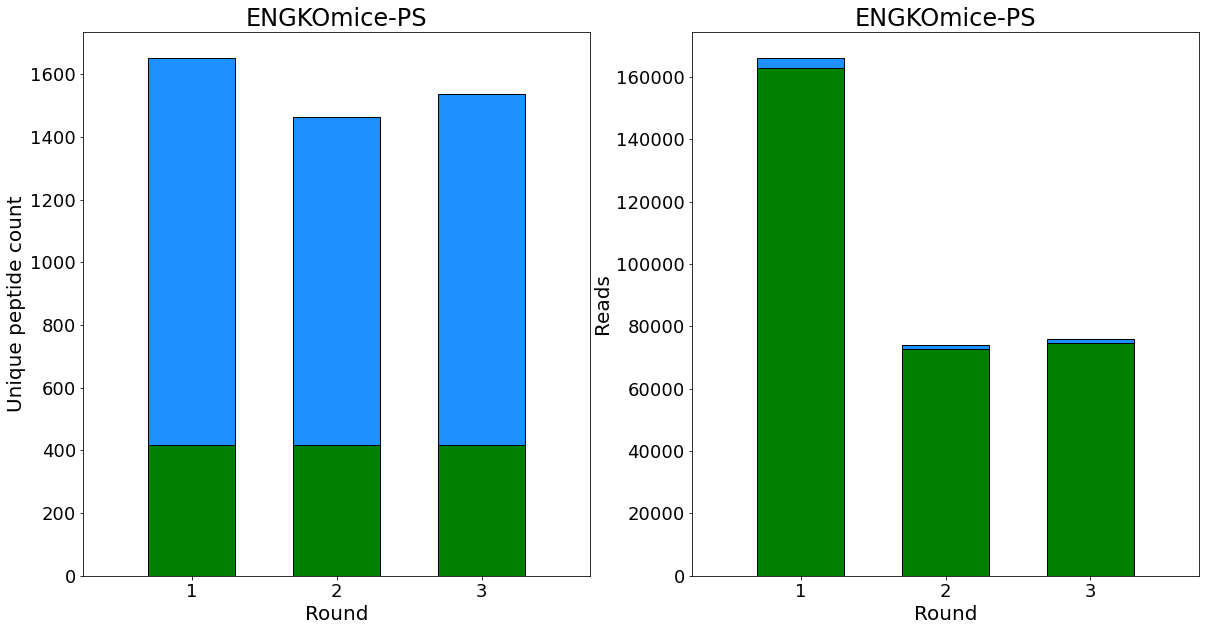

Plot1 r1:7460 r2:1601 r3:984 - green:226
Plot2 r1:332032 r2:107467 r3:36373 - green1:168729 green2:52667 green3:35517


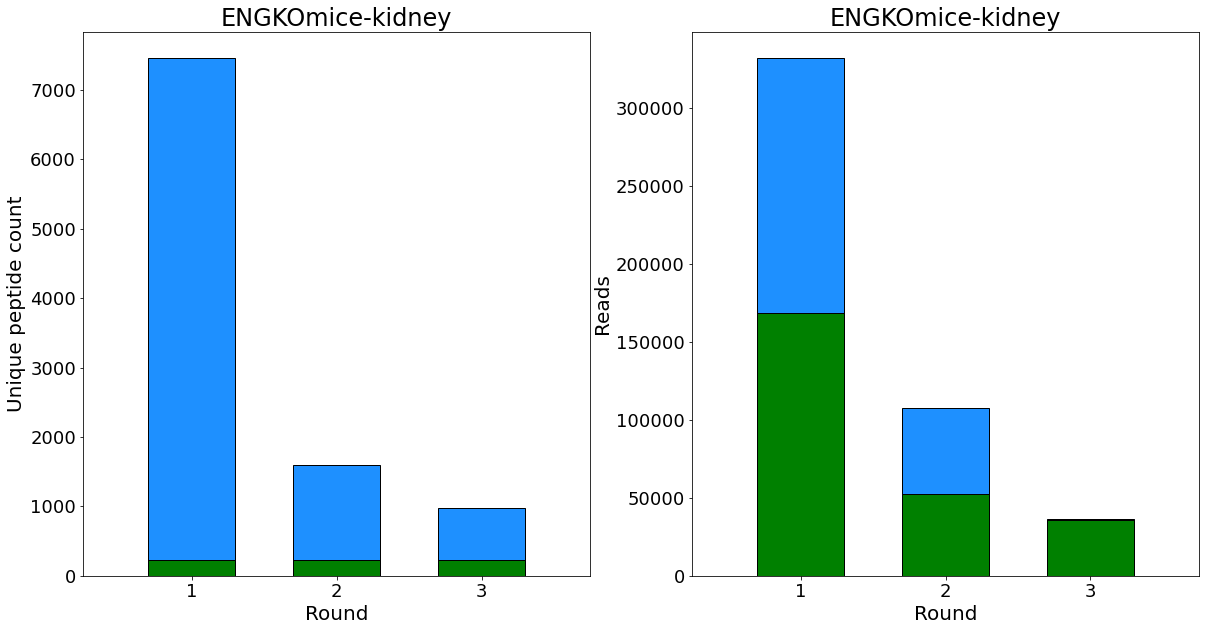

Plot1 r1:35226 r2:22540 r3:9849 - green:1944
Plot2 r1:1367993 r2:1215233 r3:442079 - green1:622050 green2:1158347 green3:432465


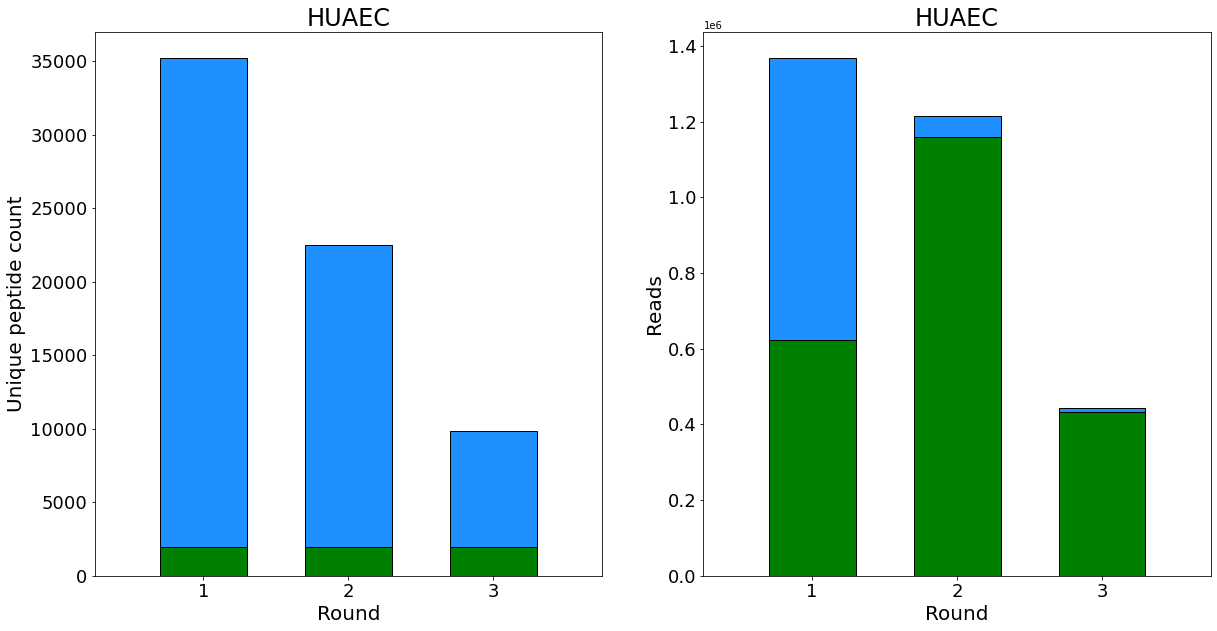

Plot1 r1:48437 r2:24469 r3:9944 - green:50
Plot2 r1:1817239 r2:1063029 r3:432515 - green1:198417 green2:232954 green3:208958


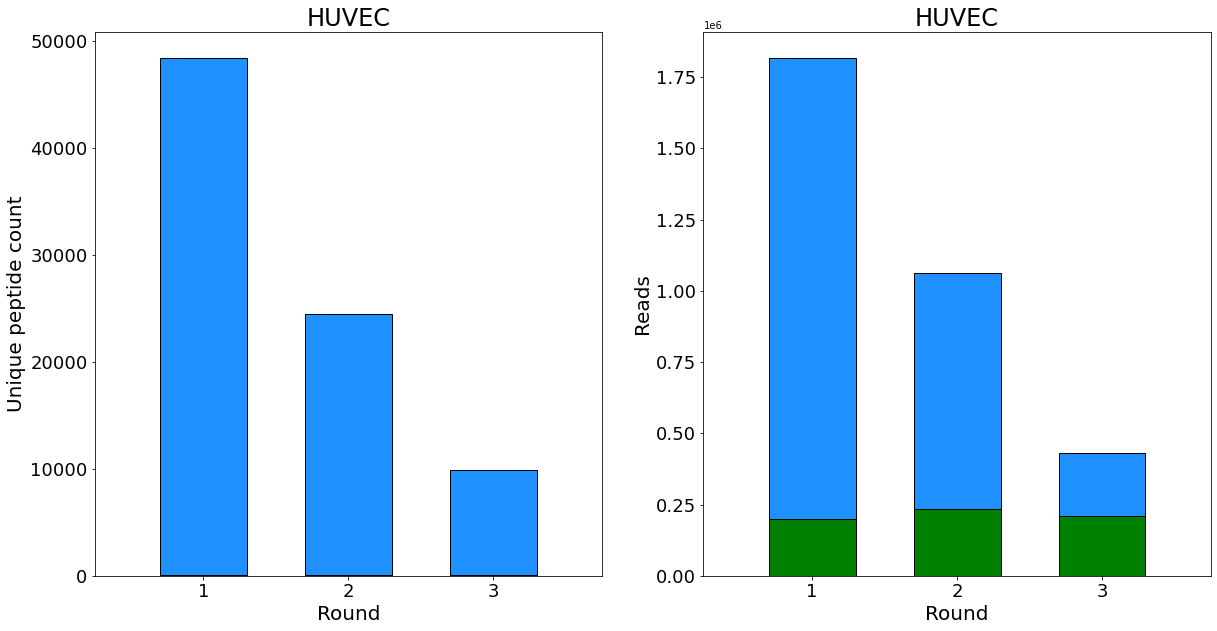

Plot1 r1:4665 r2:7911 r3:5964 - green:1257
Plot2 r1:110102 r2:218885 r3:158769 - green1:105428 green2:209300 green3:151837


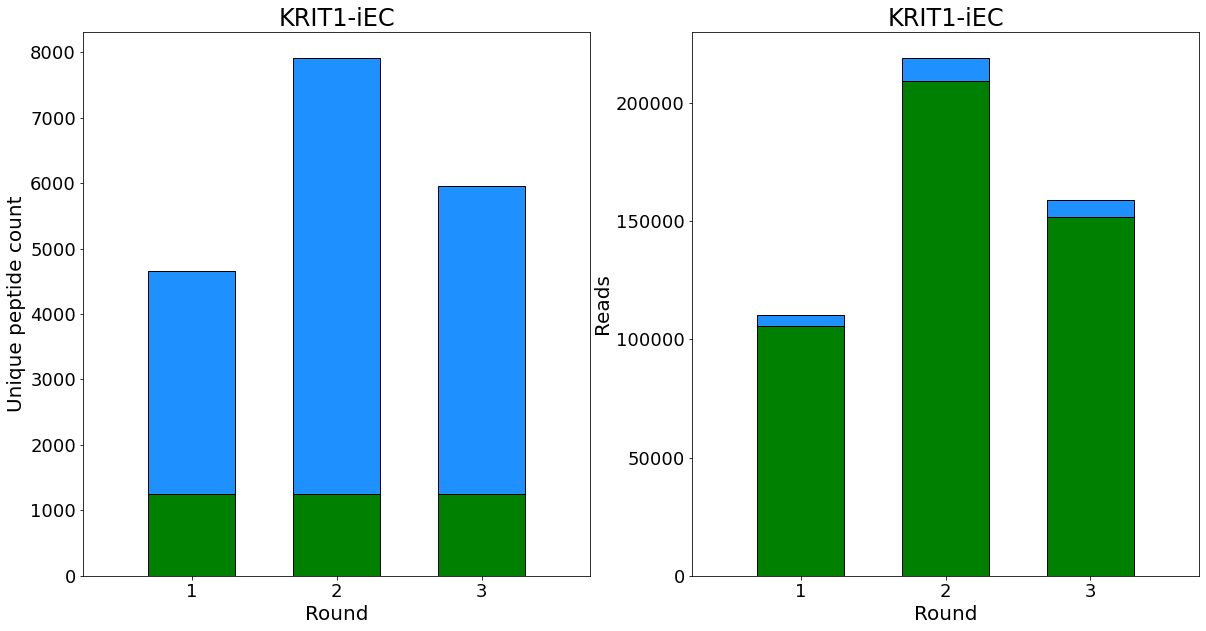

Plot1 r1:16100 r2:2861 r3:3548 - green:407
Plot2 r1:327551 r2:94649 r3:104855 - green1:48991 green2:59996 green3:51265


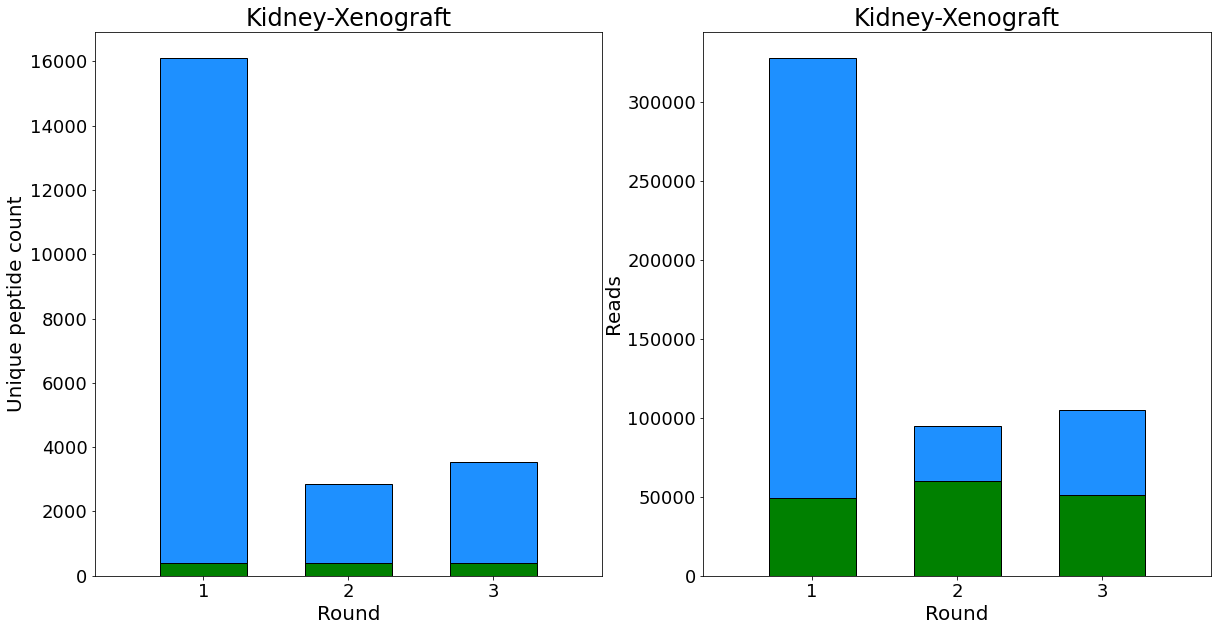

Plot1 r1:140400 r2:2515 r3:2886 - green:122
Plot2 r1:858802 r2:73369 r3:97824 - green1:6989 green2:34710 green3:65322


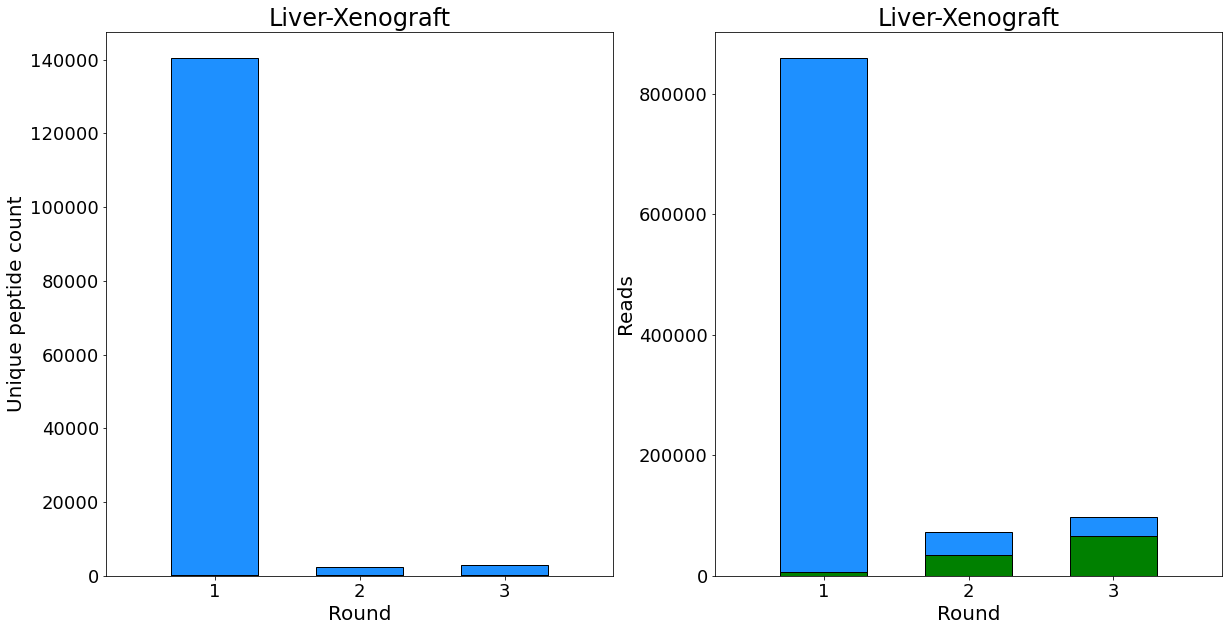

Plot1 r1:4617 r2:4516 r3:4114 - green:1263
Plot2 r1:115555 r2:104887 r3:201853 - green1:111601 green2:101067 green3:198226


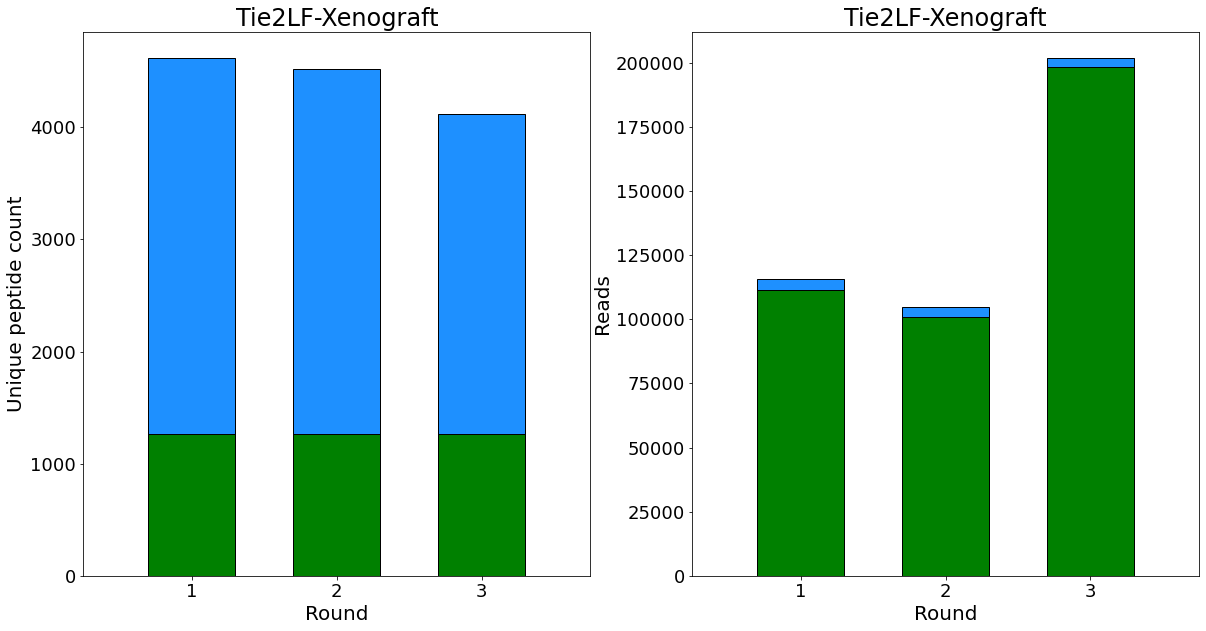

Plot1 r1:4744 r2:3716 r3:4344 - green:777
Plot2 r1:87952 r2:73341 r3:78879 - green1:74846 green2:61727 green3:66701


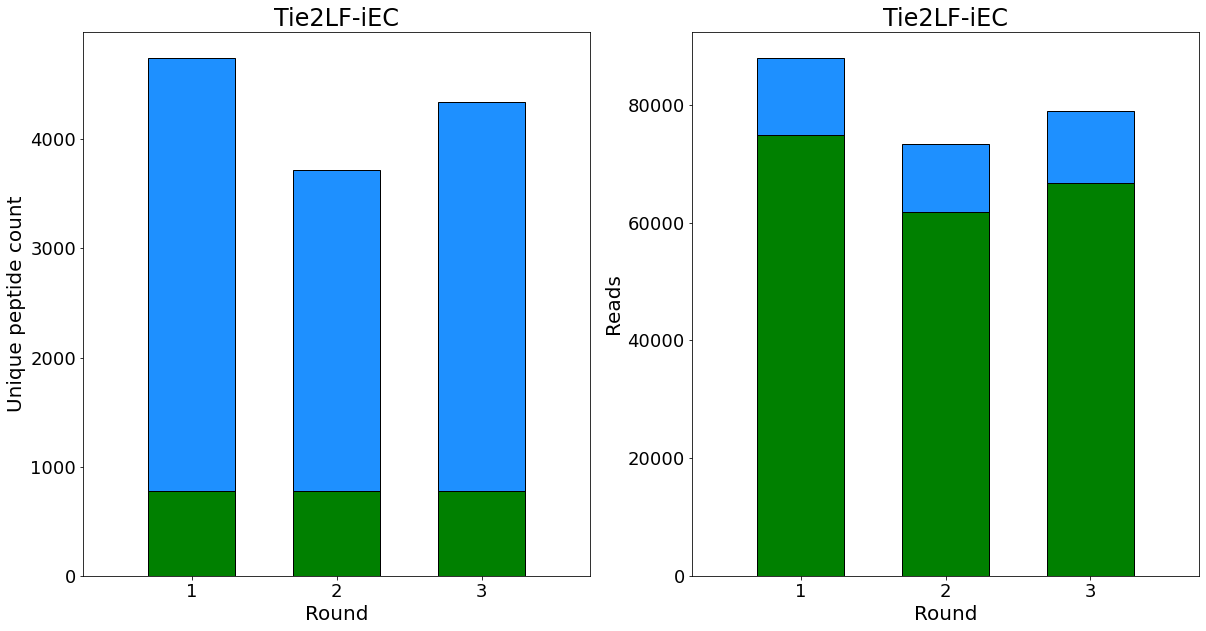

Plot1 r1:0 r2:0 r3:3550 - green:0
Plot2 r1:0 r2:0 r3:4474 - green1:0 green2:0 green3:0


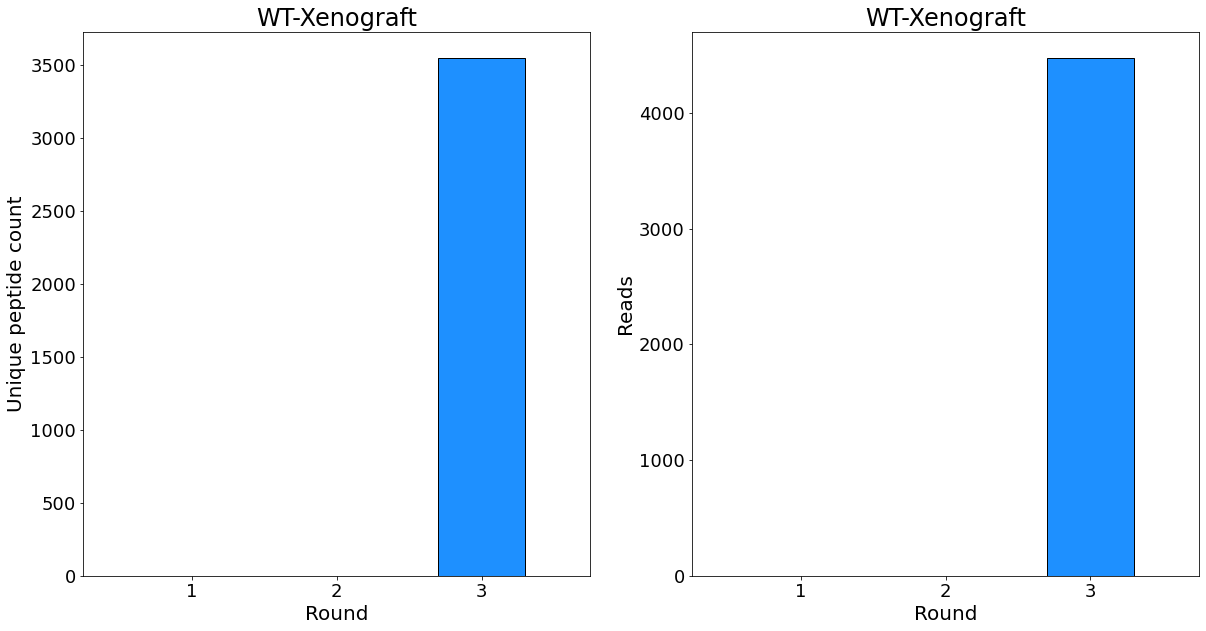

Plot1 r1:5413 r2:4838 r3:6197 - green:1178
Plot2 r1:123397 r2:120429 r3:152243 - green1:117319 green2:115361 green3:145075


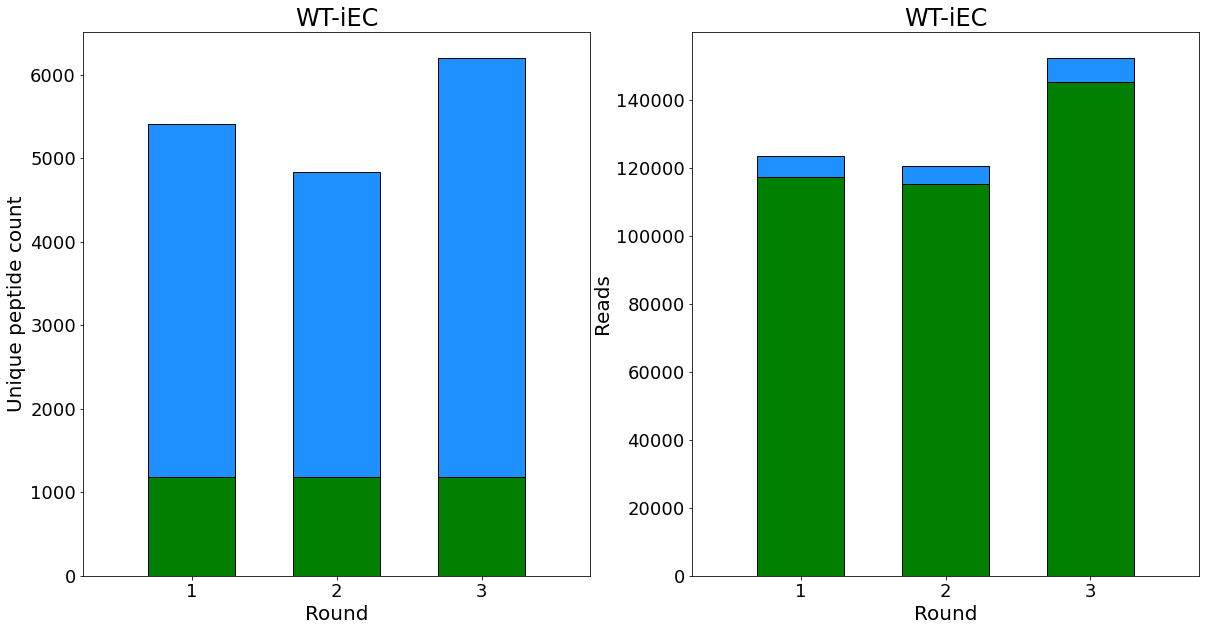

Plot1 r1:3040 r2:3108 r3:3026 - green:838
Plot2 r1:75521 r2:80373 r3:76935 - green1:70892 green2:75381 green3:72332


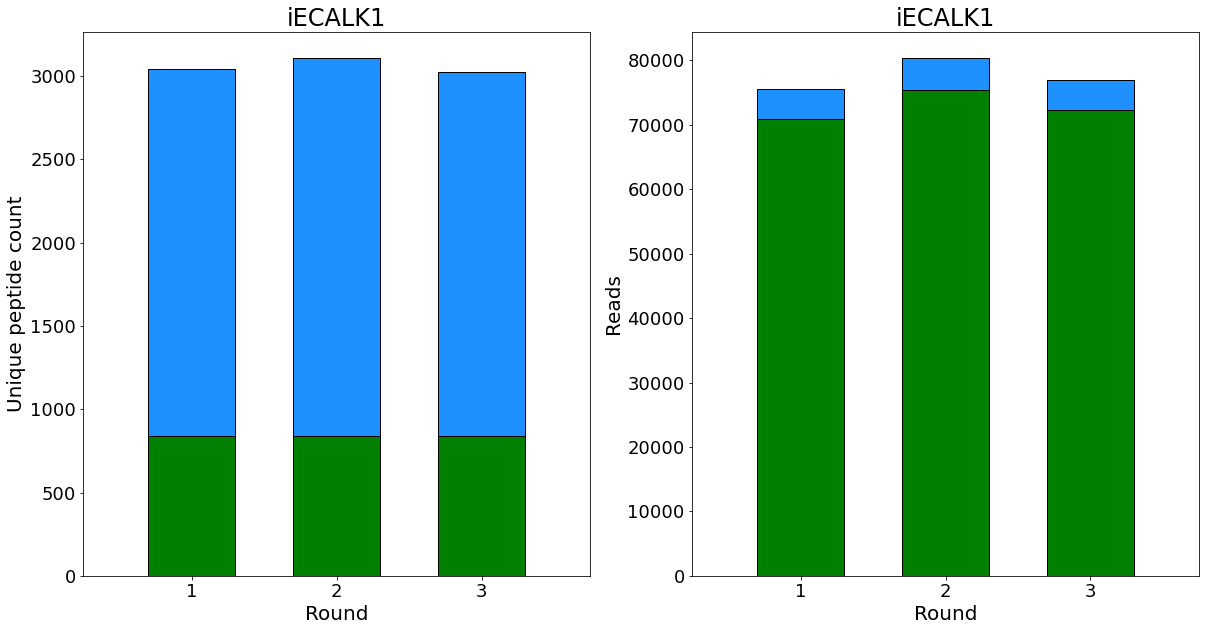

In [24]:
for g,df in mydf.groupby(['cell_line']):#,'library']):
    #display(etdf.cell_line.unique())
    #if g != 'Tie2LF-Xenograft': continue
    t1 = set(df[df['round']==1]['Protein'])
    t2 = set(df[df['round']==2]['Protein'])
    t3 = set(df[df['round']==3]['Protein'])
    #break
    barw=0.6
    fig, ax = plt.subplots(1, 2, figsize=(20,10),facecolor='w')
    ax[0].bar('1',height=len(t1),color='dodgerblue',edgecolor='k',width=barw)    
    ax[0].bar('2',height=len(t2),color='dodgerblue',edgecolor='k',width=barw)
    ax[0].bar('3',height=len(t3),color='dodgerblue',edgecolor='k',width=barw)
    ax[0].bar('1',height=len(t3&t1&t2),color='green',edgecolor='k',width=barw)
    ax[0].bar('2',height=len(t3&t1&t2),color='green',edgecolor='k',width=barw)
    ax[0].bar('3',height=len(t3&t1&t2),color='green',edgecolor='k',width=barw)
    #ax[0].plot([-1,3],[len(t3&t1&t2),len(t3&t1&t2)],c='k',linewidth=3,linestyle='--')
    print('Plot1 r1:{} r2:{} r3:{} - green:{}'.format(len(t1),len(t2),len(t3),len(t3&t1&t2)))

    ax[0].set_title(g,size=24)
    ax[0].set_ylabel('Unique peptide count',size=20)
    ax[0].set_xlabel('Round',size=20)
    ax[0].tick_params(axis='both', labelsize=18)
    ax[0].set_xlim(-0.75,2.75)
    #ax[0].set_xlim(-0.5,2.5)
    
    commonPset = t3&t1&t2
    comdf = df[df['Protein'].isin(commonPset)]
    comdic = defaultdict(list)
    for r,df2 in comdf.groupby('round'):
        for c,p in zip(df2.Count,df2.Protein):
            comdic[r] = comdic[r]+c*[p]
    g1 = df[df['round']==1]['Count'].sum()
    g2 = df[df['round']==2]['Count'].sum()
    g3 = df[df['round']==3]['Count'].sum()
    
    ax[1].bar('1',height=g1,color='dodgerblue',edgecolor='k',width=barw)    
    ax[1].bar('2',height=g2,color='dodgerblue',edgecolor='k',width=barw)
    ax[1].bar('3',height=g3,color='dodgerblue',edgecolor='k',width=barw)
    #ax[1].bar('2',height=len(t2&t1),color='red',edgecolor='k')#,align='edge',alpha=0.6)
    #ax[1].bar('3',height=len(t3&t2),color='red',edgecolor='k')#,align='edge',alpha=0.6)
    ax[1].bar('1',height=len(comdic[1]),color='green',edgecolor='k',width=barw)
    ax[1].bar('2',height=len(comdic[2]),color='green',edgecolor='k',width=barw)
    ax[1].bar('3',height=len(comdic[3]),color='green',edgecolor='k',width=barw)
    #ax[1].plot([-1,3],[len(t3&t1&t2),len(t3&t1&t2)],c='k',linewidth=3,linestyle='--')

    ax[1].set_title(g,size=24)
    ax[1].set_ylabel('Reads',size=20)
    ax[1].set_xlabel('Round',size=20)
    ax[1].tick_params(axis='both', labelsize=18)
    ax[1].set_xlim(-0.75,2.75)
    
    #ax[1].set_xlim(-0.5,2.5)
    print('Plot2 r1:{} r2:{} r3:{} - green1:{} green2:{} green3:{}'.format(g1,g2,g3,len(comdic[1]),len(comdic[2]),len(comdic[3])))
    #print(g1-len(comdic[1]))
    #print(g2-len(comdic[2]))
    #print(g3-len(comdic[3]))
    
    plt.savefig('Figures/barplots_peptides_per_round_{}.png'.format(g),bbox_inches='tight')
    plt.show()
    plt.close()
    #break

In [142]:
cpdf = pd.DataFrame()
for g,df in mydf.groupby('cell_line'):
    upd = {}
    for g2,df2 in df.groupby('round'): 
        upd[g2] = set(df2.Protein.unique())
    if len(upd)>1: commonPeptides = upd[1]&upd[2]&upd[3]
    else: commonPeptides = upd[3]
    adf = df[df['Protein'].isin(commonPeptides)].copy()
    cpdf = pd.concat([cpdf,adf],axis=0)

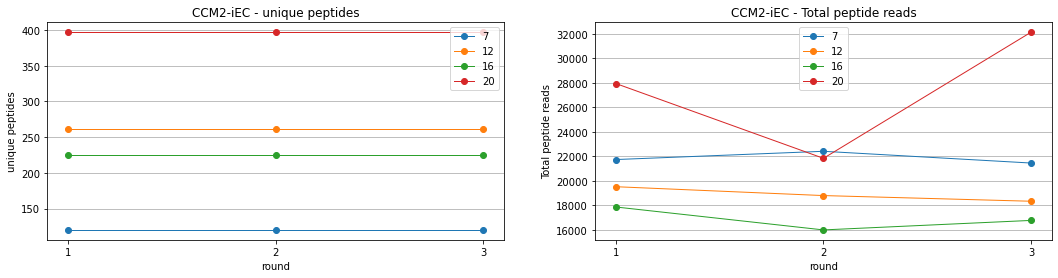

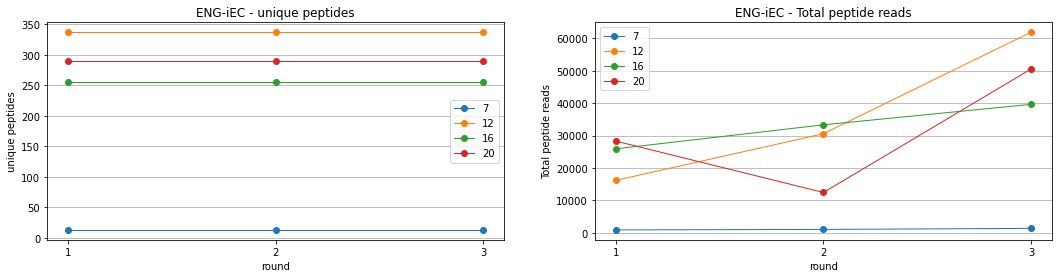

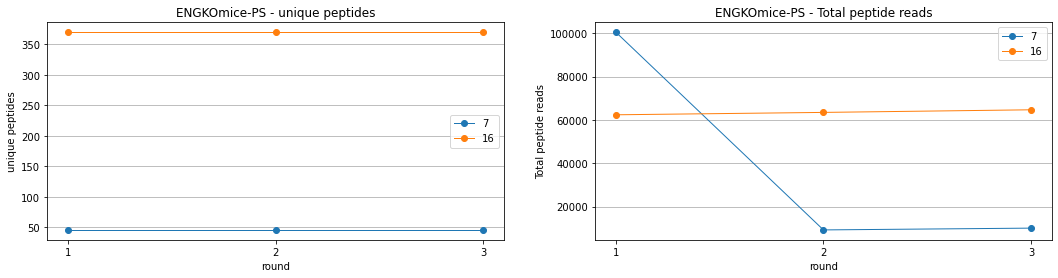

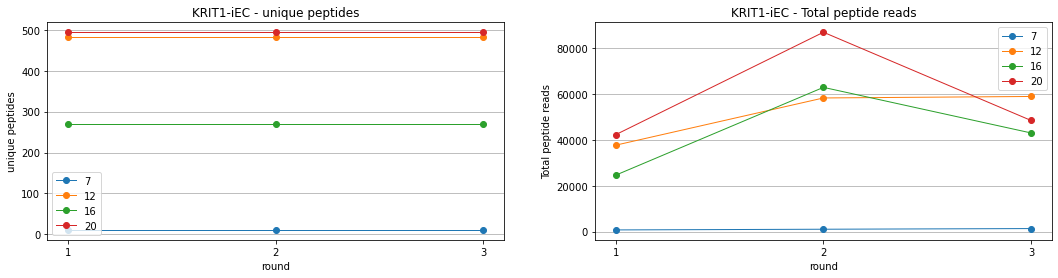

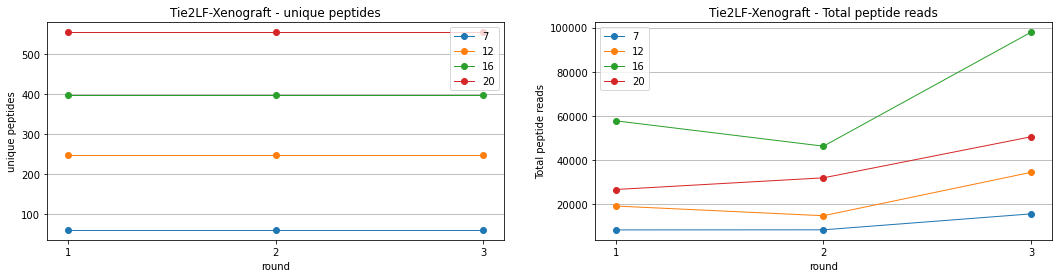

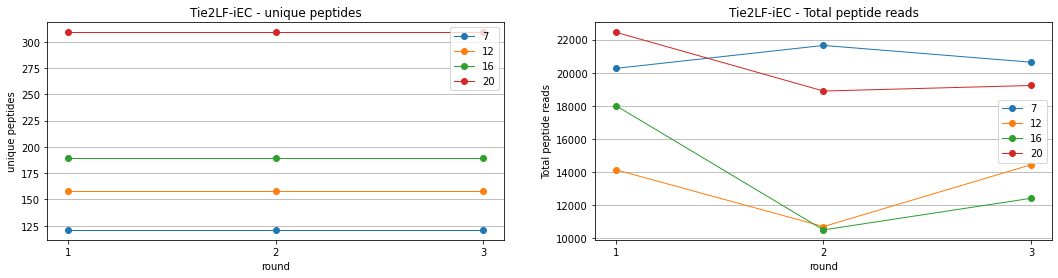

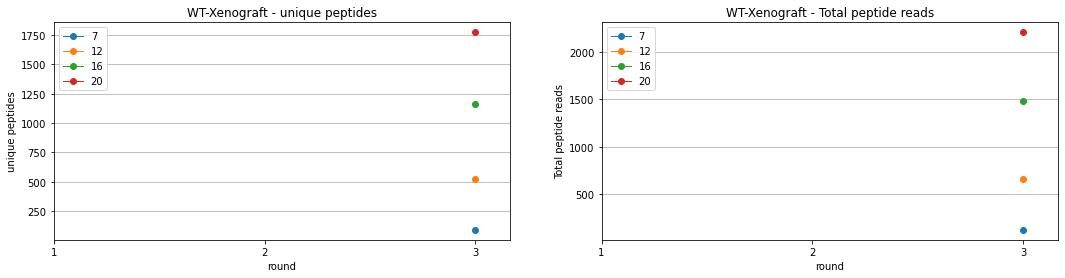

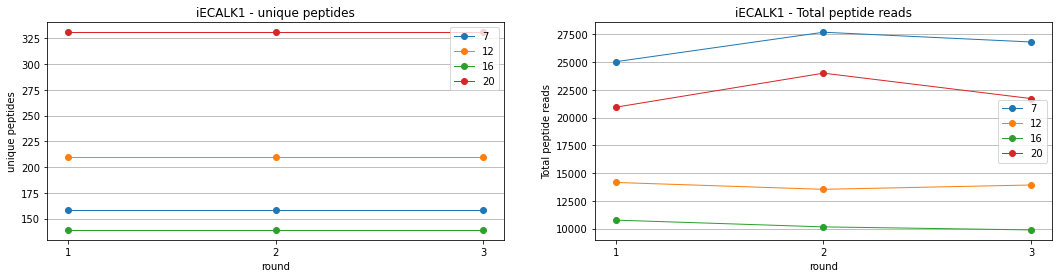

In [145]:
for g,df in cpdf.groupby('cell_line'):
    if g in ['ENGKOmice-kidney','HUAEC','HUVEC','WT-iEC','Kidney-Xenograft','Liver-Xenograft']: continue # control cell lines
    fig, axes = plt.subplots(1, 2, figsize=(18,4),facecolor='w')
    for g2,df2 in df.groupby('library'):
        xvals = []
        yvals_T = [] 
        yvals_U = [] 
        for g3,df3 in df2.groupby('round'):
            Tcount = df3.Count.sum()
            Ucount = df3.Protein.nunique()  
            xvals.append(g3)
            yvals_T.append(Tcount) 
            yvals_U.append(Ucount)
        #if 3 not in xvals: continue  
        axes[0].plot(xvals,yvals_U,linewidth=1,marker='o',label=g2)
        axes[1].plot(xvals,yvals_T,linewidth=1,marker='o',label=g2)
    axes[0].set_title('{} - unique peptides'.format(g),fontsize=12)
    axes[1].set_title('{} - Total peptide reads'.format(g),fontsize=12)
    axes[0].set_xticks([1,2,3])
    axes[1].set_xticks([1,2,3])
    axes[0].set_ylabel('unique peptides')
    axes[1].set_ylabel('Total peptide reads')
    axes[0].set_xlabel('round',size=)
    axes[1].set_xlabel('round')
    axes[0].legend()
    axes[1].legend()
    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    plt.savefig('Figures/Common_peptides_per_round_{}.png'.format(g),bbox_inches='tight')
    plt.show()
    plt.close()
    #break

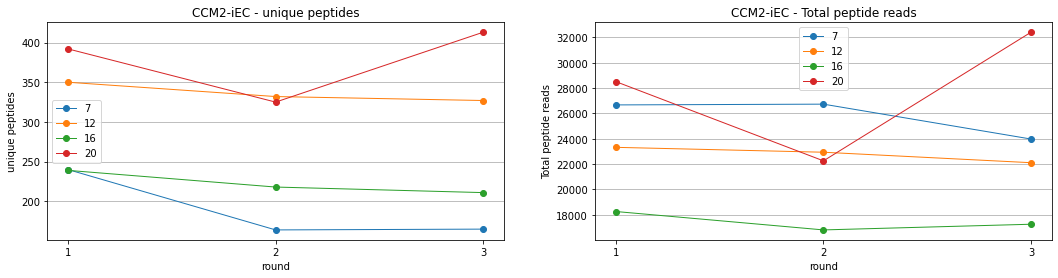

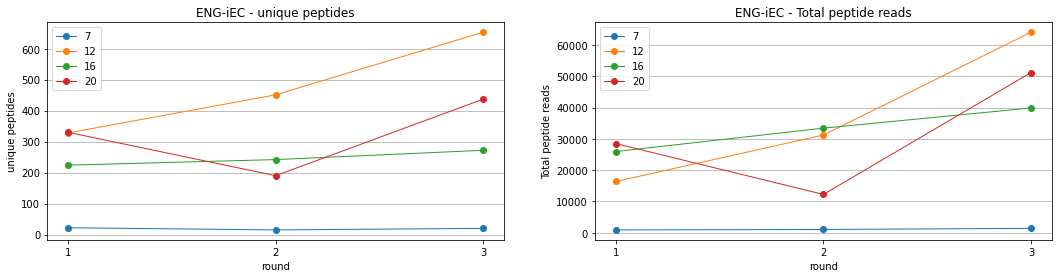

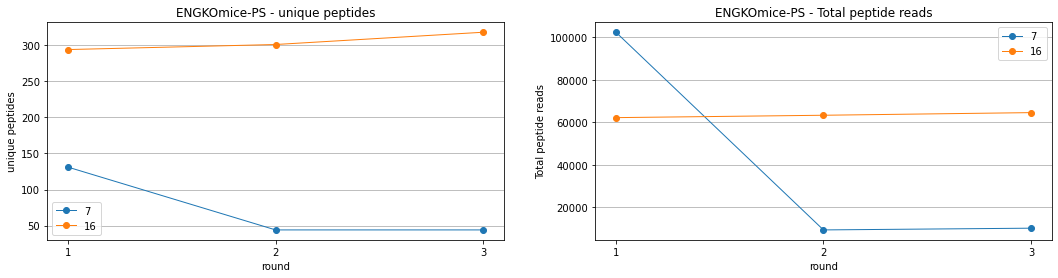

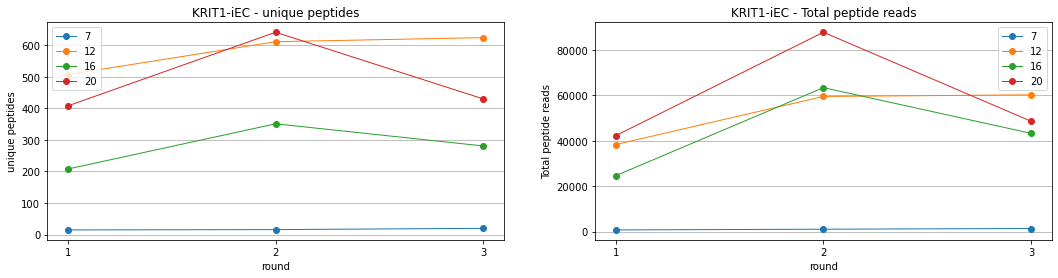

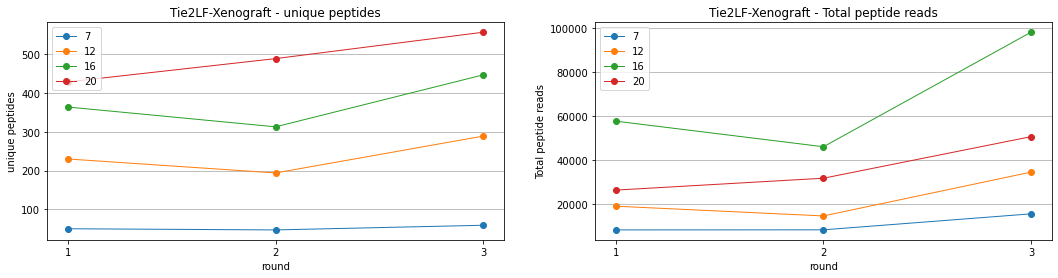

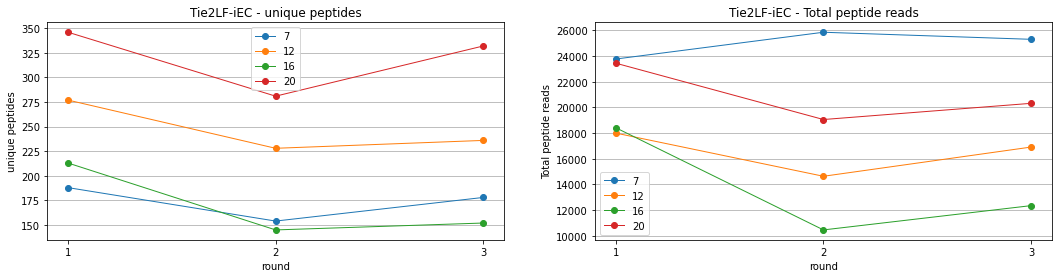

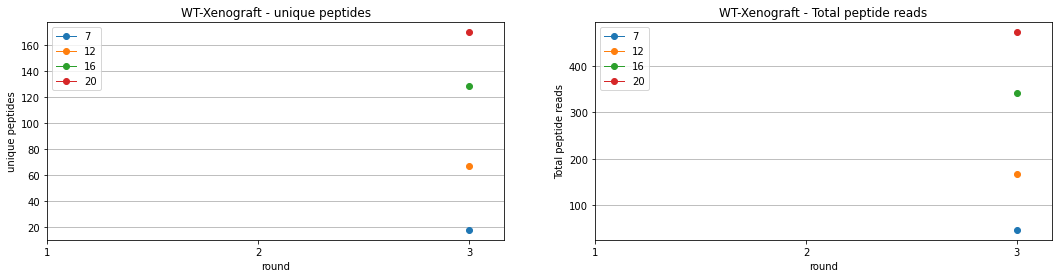

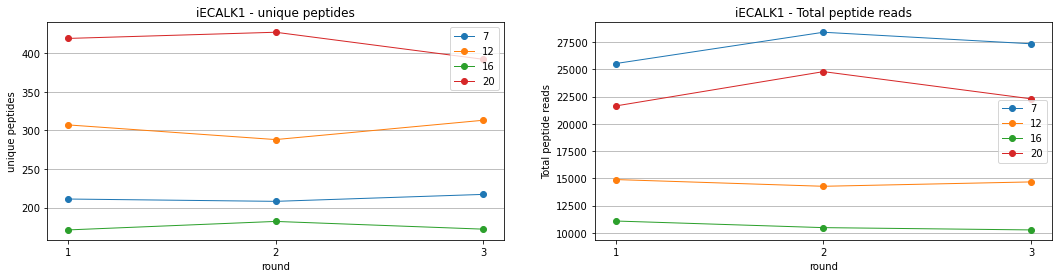

In [68]:
for g,df in mydf.groupby('cell_line'):
    if g in ['ENGKOmice-kidney','HUAEC','HUVEC','WT-iEC','Kidney-Xenograft','Liver-Xenograft']: continue # control cell lines
    fig, axes = plt.subplots(1, 2, figsize=(18,4),facecolor='w')
    for g2,df2 in df.groupby('library'):
        xvals = []
        yvals_T = [] 
        yvals_U = [] 
        for g3,df3 in df2.groupby('round'):
            Tcount = df3.Count.sum()
            Ucount = df3.Protein.nunique()  
            xvals.append(g3)
            yvals_T.append(Tcount) 
            yvals_U.append(Ucount)
        #if 3 not in xvals: continue  
        axes[0].plot(xvals,yvals_U,linewidth=1,marker='o',label=g2)
        axes[1].plot(xvals,yvals_T,linewidth=1,marker='o',label=g2)
    axes[0].set_title('{} - unique peptides'.format(g),fontsize=12)
    axes[1].set_title('{} - Total peptide reads'.format(g),fontsize=12)
    axes[0].set_xticks([1,2,3])
    axes[1].set_xticks([1,2,3])
    axes[0].set_ylabel('unique peptides')
    axes[1].set_ylabel('Total peptide reads')
    axes[0].set_xlabel('round')
    axes[1].set_xlabel('round')
    axes[0].legend()
    axes[1].legend()
    axes[0].grid(axis='y')
    axes[1].grid(axis='y')
    #plt.savefig('Figures/Unique_peptides_per_round_{}.png'.format(g),bbox_inches='tight')
    plt.show()
    plt.close()
    #break

# Enrichment of selected consensus sequences

In [2]:
mydf = pd.read_csv('all_NGS_data_combined.csv',sep=',')
slctvr3_df = pd.read_csv('clustered_data_customDist.csv',sep=',')

In [79]:
selPset = slctvr3_df['Protein'].unique()
edf0 = mydf[mydf['round']!=3]
edf = edf0[edf0['Protein'].isin(selPset)]
enrdf = pd.concat([edf,slctvr3_df])

In [80]:
#enrdf['round'] = enrdf['round'].astype(str)
#enrdf['library'] = enrdf['library'].astype(str)

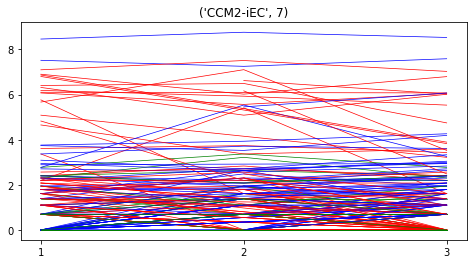

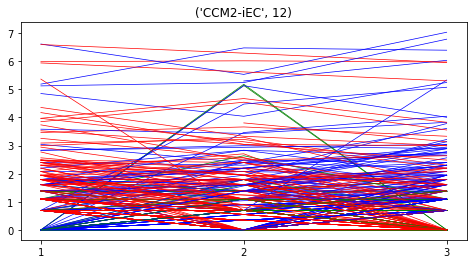

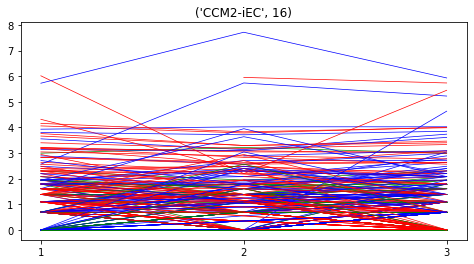

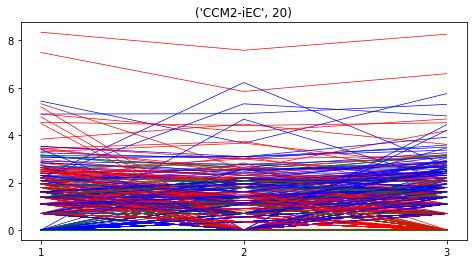

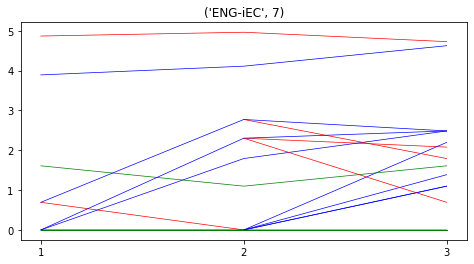

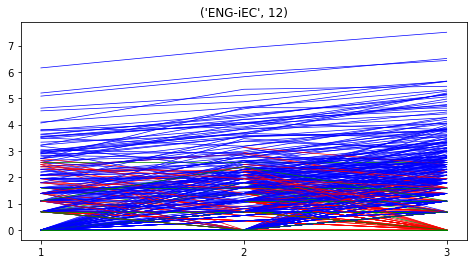

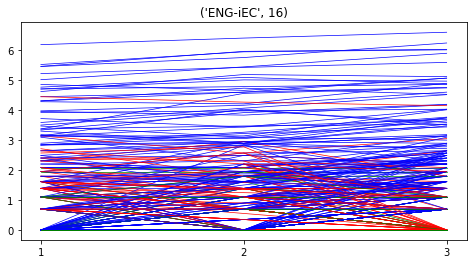

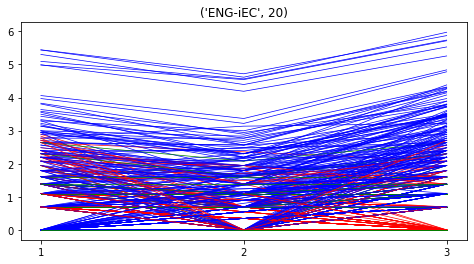

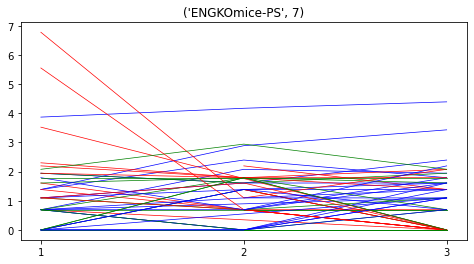

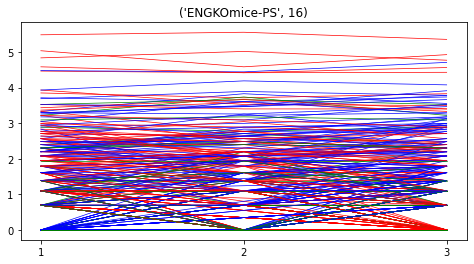

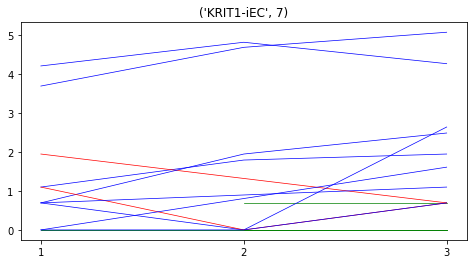

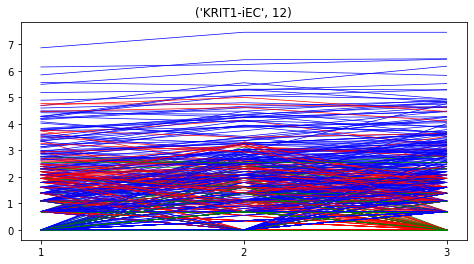

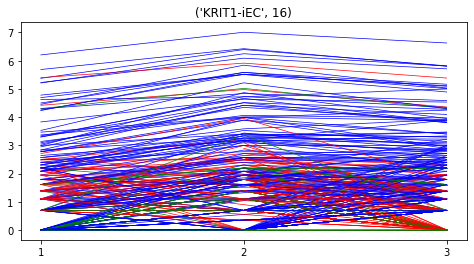

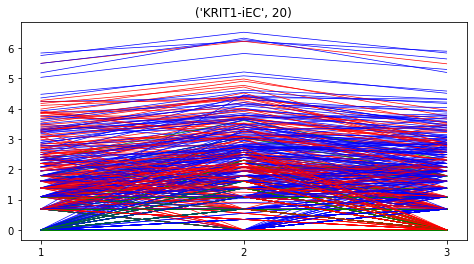

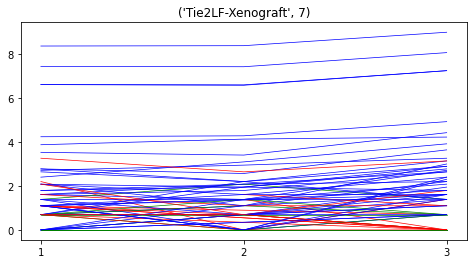

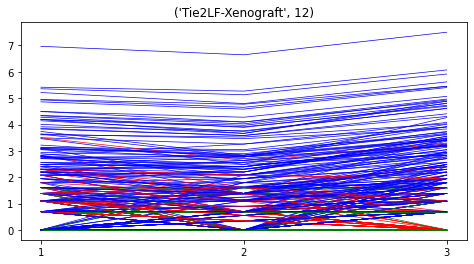

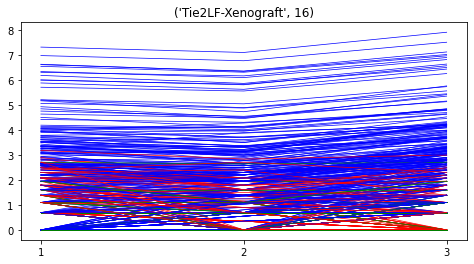

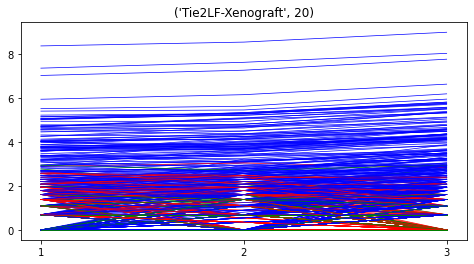

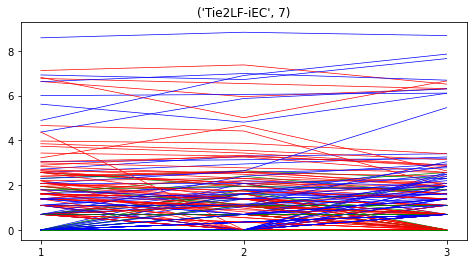

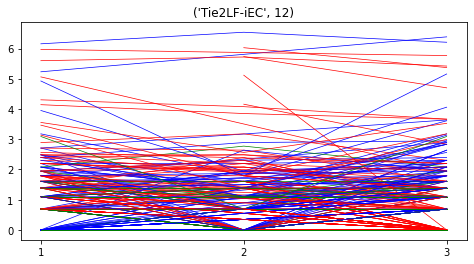

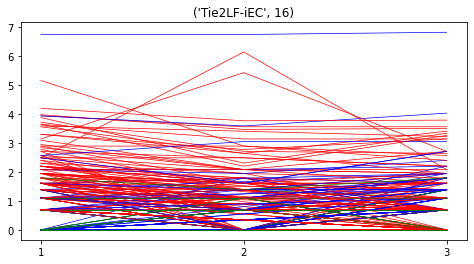

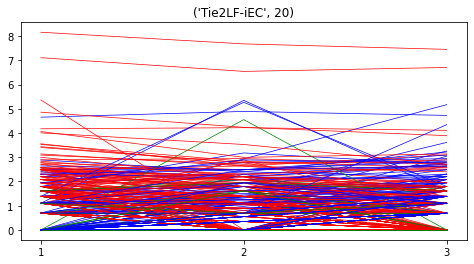

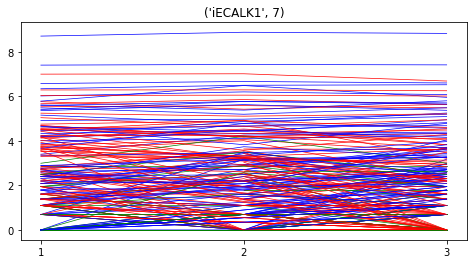

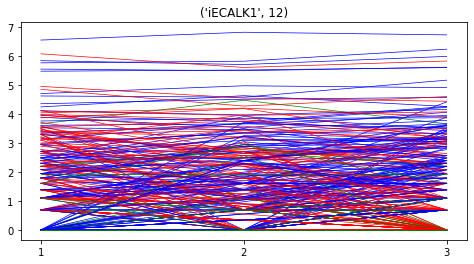

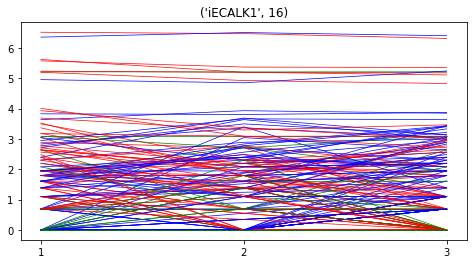

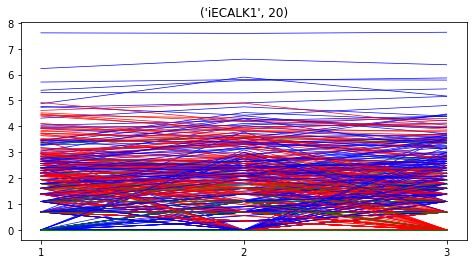

In [100]:
for g,df in enrdf.groupby(['cell_line','library']):
    if g[0] in ['ENGKOmice-kidney','HUAEC','HUVEC','WT-iEC','Kidney-Xenograft','Liver-Xenograft']: continue
    plt.figure(figsize=(8,4), facecolor='w')
    for g2,df2 in df.groupby('Protein'):
        if len(df2) > 1:
            xvals = []
            yvals = []
            for g3,df3 in df2.groupby('round'):
                xvals.append(g3)
                yvals.append(np.log(df3['Count'].sum())) 
            if 3 not in xvals: continue
            if yvals[0] < yvals[-1]: mycolor = 'blue'
            elif yvals[0] > yvals[-1]: mycolor = 'red'
            else: mycolor = 'green'        
            plt.plot(xvals,yvals,linewidth=0.7,c=mycolor)
    plt.xticks([1,2,3])
    plt.title(g)
    plt.show()
    plt.close()
    #break

In [75]:
df3

Unnamed: 0  Count  Percentage  ProteinLength  seq_count  \
fraction                                                            
Cytosol       431069      1    0.000676             17          1   
Nucleus       432083      1    0.000654             17          1   

          Naive_occurance  Normalized_abundance  cntrl_%max  cntrl_%mean  \
fraction                                                                   
Cytosol                 9                   0.0         0.0          0.0   
Nucleus                 2                   0.0         0.0          0.0   

          cntrl_rnd_and_frac_count  ClusterID  
fraction                                       
Cytosol                        0.0        0.0  
Nucleus                        0.0        0.0

# investigate the consensus sequences odrered for testing

In [55]:
mydf = pd.read_csv('all_NGS_data_combined.csv',sep=',')

In [56]:
buydict = {'CCM2-iEC':['QTSEPLEYHGGL','TLEMHLW'],
           'KRIT1-iEC':['AVKSLKTTVYSW','NPVESMLFHQRQ'],
           'ENG-iEC':['GLTHNYRDGEAK','QTAMRSSPNTATDWNYKQGV'],
           'iECALK1':['QTSMRSSPNTATYWNYKPGV','QVYSQDASCVIL'],
           'Tie2LF-iEC':['KTFVVTK','MDSSLER'],
           'Tie2LF-Xenograft':['NIHPWIPPVLNQHRSNWHAH','NQETLMMNPAGRINLGDLMA'],
           'ENGKOmice-PS':['HQEQWEWDYMADSEYQ','HGTIPPESDLGLVQAF']}

In [57]:
# we removed flanks because keeping them woud mean the similarity score between sequences would be artificially boosted.
Prot_noflnks = []
for p,l in zip(mydf['Protein'],mydf['library']):
    newp = remove_flanks(p,l)
    Prot_noflnks.append(newp)
mydf['Protein_FlanksRemoved'] = Prot_noflnks

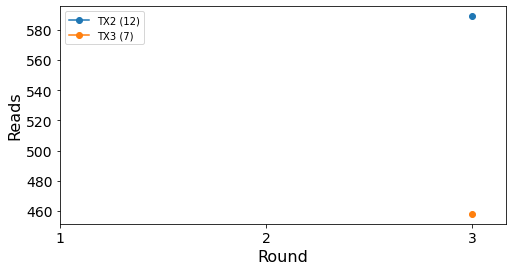

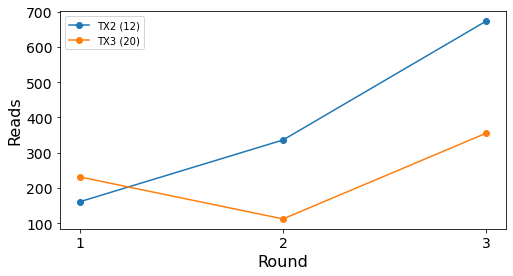

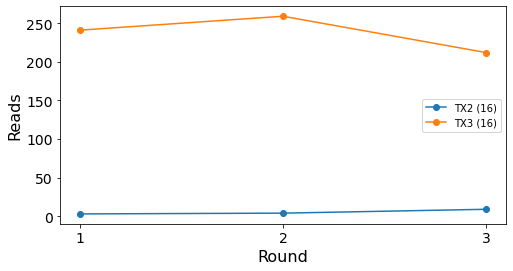

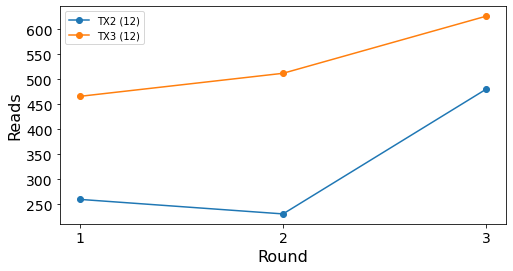

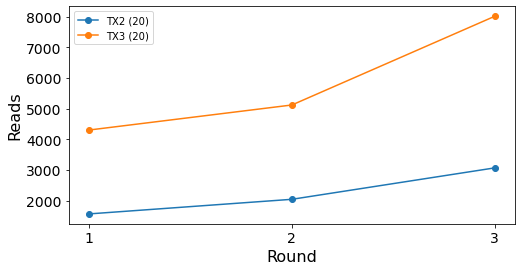

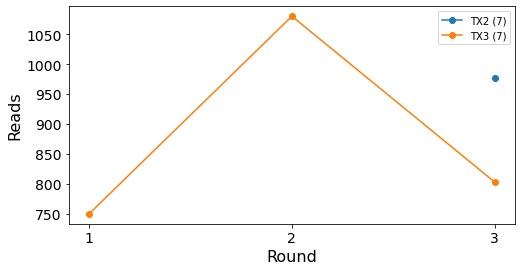

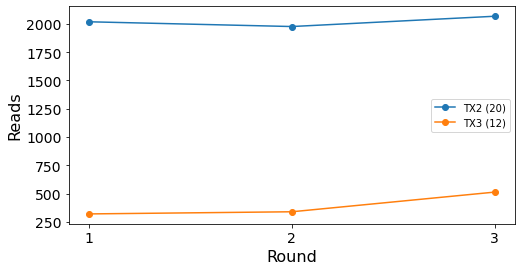

In [61]:
for g,df in mydf.groupby('cell_line'):
    if g not in buydict: continue
    pdf1 = df[df['Protein_FlanksRemoved']==buydict[g][0]]
    pdf2 = df[df['Protein_FlanksRemoved']==buydict[g][1]]
    plt.figure(figsize=(8,4), facecolor='w')
    xvals = []
    yvals = []
    for r,rdf in pdf1.groupby('round'):
        yvals.append(rdf.Count.sum())
        xvals.append(r)
    plt.plot(xvals,yvals,marker='o',label='TX2 ({})'.format(len(buydict[g][0])))
    #plt.plot(xvals,yvals,marker='o',label= buydict[g][0])
    xvals = []
    yvals = []
    for r,rdf in pdf2.groupby('round'):
        yvals.append(rdf.Count.sum())
        xvals.append(r)
    plt.plot(xvals,yvals,marker='o',label='TX3 ({})'.format(len(buydict[g][1])))
    #plt.plot(xvals,yvals,marker='o',label= buydict[g][1])
    #plt.title(g)
    plt.legend()
    plt.yticks(size=14)
    plt.xticks([1,2,3],size=14)
    plt.xlabel('Round',size=16)
    plt.ylabel('Reads',size=16)
    plt.savefig('Figures/Selected_peptides_Anon_{}.png'.format(g),bbox_inches='tight')
    plt.show()
    plt.close()

# testing and stuff

In [16]:
# logos for sequnences of round 3
print(cl)
seqs = (testdf['Protein'].unique().tolist())
counts_mat = lm.alignment_to_matrix(seqs)
print(len(seqs))
#counts_mat.head()
lm.Logo(counts_mat, color_scheme='hydrophobicity')
plt.show()
plt.close()   
lm.Logo(counts_mat, color_scheme='charge')
plt.show()
plt.close()   
lm.Logo(counts_mat, color_scheme='chemistry')
plt.show()
plt.close()   

NameError: name 'cl' is not defined

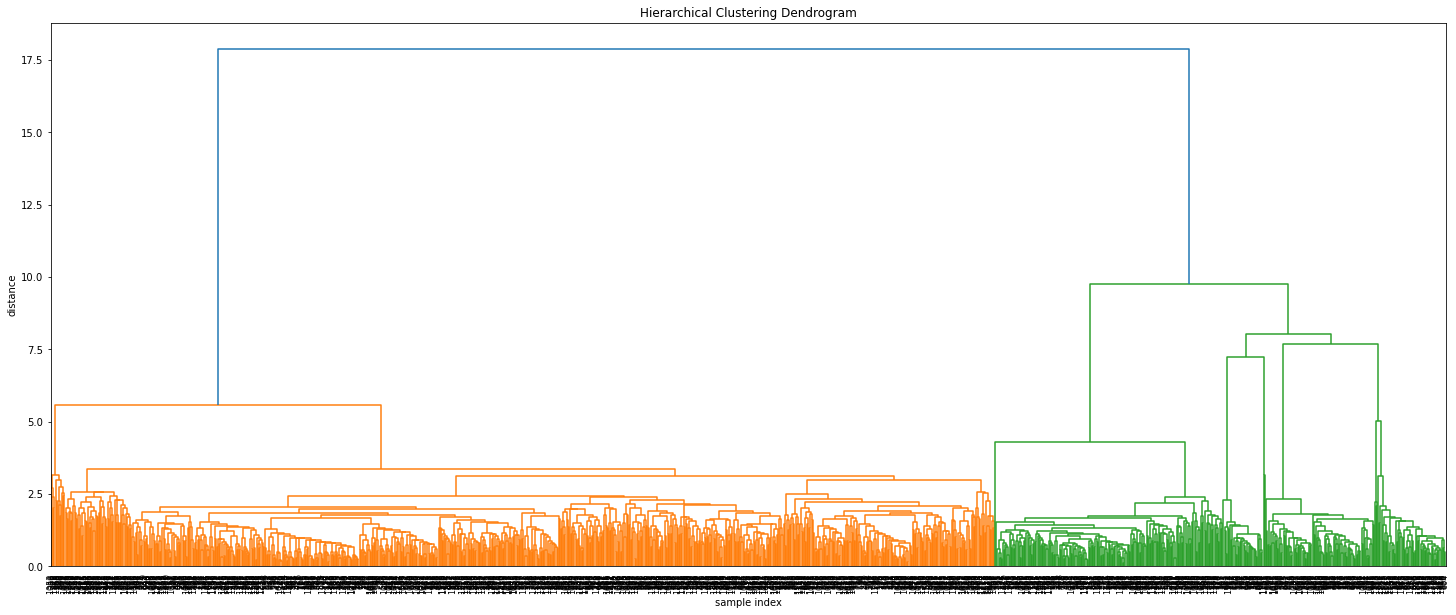

In [92]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
HIR.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

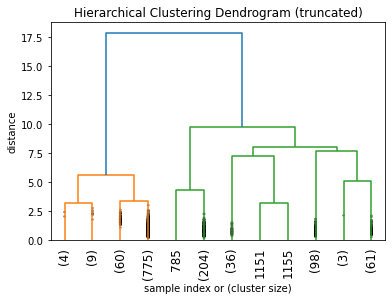

In [91]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
HIR.dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
    #annotate_above=10,  # useful in small plots so annotations don't overlap
    #max_d=4.15,  # plot a horizontal cut-off line
)
plt.show()

In [81]:
Z[2]

array([87.       , 89.       ,  0.6302287,  2.       ])

In [93]:
clusters = fcluster(Z, 2, criterion='maxclust')
clusters

array([1, 2, 1, ..., 1, 1, 2], dtype=int32)

In [ ]:
# logos for sequnences of round 3
for crlf,df in mydfr3.groupby(['cell_line','library','fraction']):
    if crlf[1]==7: continue
    if crlf[1]==16: break   
    print(crlf)
    seqs = (df['Protein'].tolist())
    counts_mat = lm.alignment_to_matrix(seqs)
    counts_mat.head()
    lm.Logo(counts_mat)
    plt.show()

# clustering using my NGS data

In [ ]:
for i in mydf.cell_line.unique():
    print(i)

### We will use Hierarchy based algorithms rather than partition based algorithms because we dont know how many clusters we have before hand.

In [ ]:
for i,df in mydf.groupby(['cell_line','library']):
    #print(i,end=' ')
    testdf0=df[df['cell_line']==i[0]]
    testdf = testdf0[testdf0['library']==i[1]]
    #print(testdf.shape[0])

In [ ]:
testdf0=mydf[mydf['cell_line']=='Tie2LF-Xenograft']
testdf = testdf0[testdf0['library']==12]

In [ ]:
simmat = np.zeros([len(testdf),len(testdf)])
for i,p1 in tqdm(enumerate(testdf['Protein'])):
    for j,p2 in enumerate(testdf['Protein']):
        if i == j: simmat[i,j] = 0
        else:
            alignment = pairwise2.align.globaldx(p1, p2, matlist.blosum62,score_only=True)
            #alignment = pairwise2.align.globalxx(p1, p2, score_only=True)
            simmat[i,j] = alignment
simmat

In [ ]:
testdf.reset_index(drop=True,inplace=True)
with open('qlucore_test_input_Tie2_xeno_12.csv','w') as outf:
    for i,d in testdf.iterrows():
        if i==0: 
            outf.write('Sample,Count,Protein,cell_line,library,round,fraction,')
            for n in range(len(simmat[0])): outf.write('{},'.format('v'+str(n)))
            outf.write('\n')
        #print(i,d)
        #break
        Sa = d['Sample']
        Co = d['Count']
        Pr = d['Protein']
        Cl = d['cell_line']
        Li = d['library']
        Ro = d['round']
        Fr = d['fraction']
        l1 = [Sa,Co,Pr,Cl,Li,Ro,Fr]
        for j in l1: outf.write('{},'.format(j))
        for k in simmat[i]: outf.write('{},'.format(k))
        outf.write('\n')